# Term Deposit Marketing - An Apziva Project

# Modeling

By Samuel Alter

Apziva: G3SuQYZYrFt9dwF3

## Project Overview

Using phone call data from a European bank, this project will be building a model that predicts if a customer will subscribe to a term deposit, a type of financial product. This project is a partnership with a startup focused on providing ML solutions for European banks.

### Goals

The startup is hoping that I can **achieve ≥81% accuracy** using a 5-fold cross validation strategy, taking the average performance score.

Bonus goals include:
* Determining which customers are most likely to buy the term deposit loan
  * Which segments of customers should the client prioritize?
* Determine what makes the customer buy the loan
  * Which feature should the startup focus on?

### The dataset

Using phone call data from a European bank, this project will be building models that predict if a customer will subscribe to a term deposit, a type of financial product. This project is a partnership with a startup focused on providing ML solutions for European banks.

The dataset consists of the following columns:
* `age`
  * Numeric
  * The age of the customer
* `job`
  * Categorical
  * The job category of the customer
* `marital`
  * Categorical
  * Whether the customer is married
* `education`
  * Categorical
  * The customer's level of education
* `default`
  * Binary
  * If the customer has credit in default or not
* `balance`
  * Numeric
  * Average yearly balance in Euros
* `housing`
  * Binary
  * If the customer has a housing loan or not
* `loan`
  * Binary
  * If the customer has a personal loan
* `contact`
  * Categorical
  * The type of contact communication
* `day`
  * Numeric
  * Last contact day of the month
* `month`
  * Categorical
  * Last contact month of the year
* `duration`
  * Numeric
  * Duration of the last phone call with the customer
* `campaign`
  * Numeric
  * The number of contacts performed during this campaign and for this client, which includes the last contact

The final column, `y`, is the target of the dataset and shows whether the client subscribed to a term deposit.

## Imports and Helper Functions

In [233]:
import numpy as np
import pandas as pd
from pandas.api.types import is_string_dtype
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import joblib
import time
import threading
from datetime import datetime
# from contextlib import contextmanager
from timeit import default_timer

from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split,cross_val_score
# from pycaret.classification import setup,compare_models,create_model,plot_model,evaluate_model
# from pycaret.regression import *

# from autosklearn.classification import AutoSklearnClassifier
import optuna

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
# import sklearn.lda.LDA as LDA # <-- this is throwing the ModuleNotFoundError

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from collections import defaultdict

import shap

In [7]:
# simple function to generate random integers

def rand_gen(low=1,high=1e4):
    '''
    Generates a pseudo-random integer
    consisting of up to four digits
    '''
    import numpy as np
    rng=np.random.default_rng()
    random_state=int(rng.integers(low=low,high=high))
    
    return random_state

In [8]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    SOURCE: https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py

    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html

    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

    if title:
        plt.title(title)

In [9]:
seed=rand_gen()
seed

4769

In [10]:
test_size=0.2
test_size

0.2

In [11]:
# set the randomness seed throughout the notebook
# source: # https://odsc.medium.com/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752

## set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed)
## set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed)
## set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed)
np.random.default_rng(seed)

Generator(PCG64) at 0x16984BAC0

In [12]:
import json
from pathlib import Path
import inspect

def get_variable_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [name for name, val in callers_local_vars if val is var]

def fileDaterSaver(location: str,
                   filetype: str,
                   object_,
                   extra: str = '',
                   verbose: bool = True):

    '''
    Function that gets a timestamped filename and saves it
    to a user-specified location.

    Parameters:
    -----------
    location: str - The location where the file will be saved.
    filetype: str - The type of the file to save ('csv' or 'json').
    object_: The object to be saved. Should be a pandas DataFrame
        for 'csv' or serializable for 'json'.
    extra: str - Additional string to include in the filename.
    verbose: bool - Whether to print verbose messages.
    '''

    # get current date and time
    current_datetime = datetime.now()

    # print current date and time to check
    if verbose:
        print('current_datetime:', current_datetime)

    # format the datetime for a filename
    datetime_suffix = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

    # create filename with the datetime suffix
    if extra != '':
        file_name = f'{location}{extra}_{datetime_suffix}.{filetype}'
    else:
        file_name = f'{location}{datetime_suffix}.{filetype}'

    # print file name
    if verbose:
        print(file_name)

    # save object
    if filetype == 'csv':
        object_.to_csv(file_name, index=True)
    elif filetype == 'json':
        with open(file_name, 'w') as file:
            file.write(json.dumps(object_, default=str))
    else:
        raise ValueError("Unsupported file type. Use 'csv' or 'json'.")

    # confirm save
    file_path = Path(file_name)
    if file_path.exists():
        variable_name = get_variable_name(object_)
        if variable_name:
            print(f'Successfully saved {variable_name[0]} to {file_path}')
        else:
            print(f'Successfully saved object to {file_path}')
    else:
        print("File save error.")

In [13]:
# read in data
df=pd.read_csv('../data/2_data.csv')
df.head(3)

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   

   contact  day month  duration  campaign   y  
0  unknown    5   may       261         1  no  
1  unknown    5   may       151         1  no  
2  unknown    5   may        76         1  no

## Goals recap

To achieve this project's goals, we have to run models. As a reminder, this project is aiming to predict customer behavior. Specifically, we are training models to determine if a customer will buy a term deposit loan.

We are aiming to achieve ≥81% accuracy with the modeling
  * Use a 5-fold cross validation strategy and take the average performance score.

Bonus goals include:
* Determine which customers are most likely to buy the term deposit loan
  * Which segments of customers should the client prioritize?
* Determine what makes the customer buy the loan
  * Which feature should the startup focus on?

## Will a Customer Receive a Loan?
`AutoSklearn` to  `Optuna` to `scikit-learn`: the Modeling Workflow

I will first use [`AutoSklearn`](#https://automl.github.io/auto-sklearn/master/#) to help me explore the ML algorithm landscape to identify the best-performing models for this particular dataset.

In order to find the best hyperparameters for our modeling, I will use [`Optuna`](#https://optuna.readthedocs.io/en/stable/index.html). This is similar to other frameworks like [`Hyperopt`](#http://hyperopt.github.io/hyperopt/), which are designed to quickly and efficiently find the best hyperparameters for your dataset.

Finally, we will use `sklearn` to build the final, optimized model.

### Notes on project setup:

We want to help the bank understand which customers are most likely to purchase the financial product. Knowing this would save the bank time and money. The dataset that we were given consists of demographic (and banking) data (like `age`,`job`,`marital`,and `balance`) as well as campaign-specific information (like `contact`,`day`,and `duration`).

*Demographic and Banking Data*
* `age`
* `job`
* `marital`
* `education`
* `default`
* `balance`
* `housing`
* `loan`

*Campaign-Specific Data*
* `contact`
* `day`
* `month`
* `duration`
* `campaign`

*Target Feature*
* `y`

We want to build a three-layered ML system that helps answer the project goals:
1. Understand which kinds of customers that they should call
 1. I will **not** give the model access to the campaign call data
1. After the initial calls, understand which customers the company should keep calling
 1. Give the model access to the campaign call data
1. Build a model using unsupervised learning to learn about clusters of customers in the dataset

**Layer 1**:  

Use `X_1` to model which customers to make calls to. We are training a model that does not know any call data, so this is *before* making calls.

**Layer 2**:  

Use the full `X` dataset (for clarity in its use in the layer flow, we'll be using `X_2` to model which customers the company should keep calling.

**Layer 3**:  

Use unsupervised learning to uncover how the customers are grouped.

### Setup X

In [19]:
dbd=[ # demographic and banking data
    'age',
    'job',
    'marital',
    'education',
    'default',
    'balance',
    'housing',
    'loan'
]

csd=[ # campaign-specific data
    'contact',
    'day',
    'month',
    'duration',
    'campaign'
]

`_1` refers to the first layer of the model, consisting of demographic and banking data, not including data related to the campaign. This simulates new customers that haven't received a call yet. This helps answer the main question of the project, namely to train a model that predicts which customer will receive a loan.

In [20]:
X_1=df[[col for col in df.columns if col != 'y' and col not in csd]]
y=df['y']
y=y.map({'yes':1,'no':0})

`_2` refers to the second layer of the model, consisting of all columns. This helps answer the first bonus question of the project, which is to determine which customers the bank should prioritize calling to: those most likely to receive a loan.

In [21]:
X_2=df[[col for col in df.columns if col != 'y']]

`_3` refers to the third layer of the model, consisting of all columns. This helps answer the another bonus question: can we train an unsuperived learning model that groups the customers into categories?

In [22]:
X_3=df[[col for col in df.columns if col != 'y']]

In [23]:
df

age           job   marital  education default  balance housing loan  \
0       58    management   married   tertiary      no     2143     yes   no   
1       44    technician    single  secondary      no       29     yes   no   
2       33  entrepreneur   married  secondary      no        2     yes  yes   
3       47   blue-collar   married    unknown      no     1506     yes   no   
4       33       unknown    single    unknown      no        1      no   no   
...    ...           ...       ...        ...     ...      ...     ...  ...   
39995   53    technician   married   tertiary      no      395      no   no   
39996   30    management    single   tertiary      no     3340      no   no   
39997   54         admin  divorced  secondary      no      200      no   no   
39998   34    management   married   tertiary      no     1047      no   no   
39999   38    technician   married  secondary      no     1442     yes   no   

        contact  day month  duration  campaign    y  
0       unknown    5   may       261         1   no  
1       unknown    5   may       151         1   no  
2       unknown    5   may        76         1   no  
3       unknown    5   may        92         1   no  
4       unknown    5   may       198         1   no  
...         ...  ...   ...       ...       ...  ...  
39995  cellular    3   jun       107         1   no  
39996  cellular    3   jun       238         3  yes  
39997  cellular    3   jun       170         1  yes  
39998  cellular    3   jun       342         1   no  
39999  cellular    3   jun       113         1   no  

[40000 rows x 14 columns]

Make function to automate the training of the AutoSklearn pipeline:

In [16]:
def detectCatCont(X,verbose=False):
    '''
    Helper function for detecting categorical and continuous
    features in a dataset. It returns the categorical and
    continuous features as a tuple.
    '''

    # detect categorical and continuous features
    categorical_features = X.select_dtypes(
        include=['object', 'category']).columns.tolist()
    continuous_features = X.select_dtypes(
        include=['int64', 'float64']).columns.tolist()

    if verbose:
        print('Categorical and continuous features detected')

    return categorical_features,continuous_features

In [17]:
def defPreprocessor(categorical_features,continuous_features,verbose=False,custom_preprocessor=None):
    '''
    Helper function for returning a custom preprocessor for
    processing a dataframe, or one that is defined
    within the function. It returns the custom or
    function-created preprocessor.
    '''

    if custom_preprocessor is not None:
        if verbose:
            print('Using custom preprocessor')
        return custom_preprocessor

    # Define the preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(), categorical_features),
            ('num', StandardScaler(), continuous_features)
        ]
    )

    if verbose:
        print('Preprocessor created')
        print('categorical_features:', categorical_features)
        print('continuous_features:', continuous_features)

    return preprocessor

In [18]:
def trainTestSplits(X,y,test_size,seed,verbose=False):
    '''
    Helper function that automates the train_test_split function within scikit-learn
    and returns them as a dictionary.
    '''

    # create train/test splits
    X_train, X_test, y_train, y_test = train_test_split\
    (X, y, test_size=test_size, random_state=seed,stratify=y)

    if verbose:
        print('Training and testing splits created')

    splits={
        'X_train':X_train,
        'X_test':X_test,
        'y_train':y_train,
        'y_test':y_test
        }

    return splits

In [19]:
def defPipeline(time_for_task,seed,preprocessor,verbose=False):
    '''
    Helper function that creates the pipeline from a previously-defined
    preprocessor. Returns the pipeline.
    '''

    # Define Auto-sklearn classifier and pipeline
    automl = AutoSklearnClassifier(
        time_left_for_this_task=time_for_task,
        seed=seed
    )
    pipeline = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('classifier', automl)
        ]
    )

    if verbose:
        print('AutoSklearnClassifier and pipeline created')

    return pipeline

In [20]:
def evaluateModel(X_test,y_test,pipeline,verbose=False):
    '''
    Helper function that returns a tuple of predictions on
    the model and the accuracy.
    '''

    # evaluate the model
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    if verbose:
        print(f"AutoSklearn accuracy:\n{accuracy*100:.2f}%")

    return y_pred,accuracy

In [21]:
def returnTopModels(pipe_path,score=0.9):
    '''
    Returns the most common classifiers achieving a mean_test_score of over 90% accuracy.
    This value can be changed in the function.
    '''

    # load pipeline and splits
    pipeline=joblib.load(pipe_path)

    # access the AutoSklearnClassifier from the pipeline
    automl_model = pipeline.named_steps['classifier']

    # access the cross-validation results
    cv_results=pd.DataFrame(automl_model.cv_results_)

    cv_results_=\
        cv_results[
            (cv_results['status'] == 'Success') & \
            (cv_results['mean_test_score']>score)
        ]\
    .sort_values(by='mean_test_score', ascending=False)

    cv_results_over90=cv_results_['param_classifier:__choice__'].value_counts()

    return cv_results_over90

In [22]:
def run_autosklearn_pipeline(X,y,seed,test_size,save_location,filename,verbose=False,time_for_task=3600,return_tops=True):
    '''
    Function that runs the AutoSklearnClassifier.
    Outputs a dictionary of the test_train_split'ed dataset ("splits")
    and the created pipeline object.

    It also returns the top-performing models
    that achieve an accuracy of over 90%.

    Arguments:
    X - the features dataset
    y - the target dataset
    seed - the random seed
    test_size - the test_size fraction for train_test_split
    save_location - the location where the splits and pipeline are located
    filename - what to call these two objects
    verbose - verbosity flag
    time_for_task - using the AutoSklearnClassifier default value

    Outputs:
    splits - a dictionary of X_train,X_test,y_train,y_test
    pipeline - the trained AutoSklearnClassifier pipeline
    '''

    categorical_features,continuous_features=detectCatCont(X,verbose)

    preprocessor=defPreprocessor(categorical_features,continuous_features,verbose)

    splits=trainTestSplits(X,y,test_size,seed,verbose)

    X_train=splits['X_train']
    X_test=splits['X_test']
    y_train=splits['y_train']
    y_test=splits['y_test']

    pipeline=defPipeline(time_for_task,seed,preprocessor,verbose)

    # start training
    if verbose:
        print(f"\nTraining the pipeline... (This may take up to {time_for_task//60} minutes)\n")
        print()
    pipeline.fit(X_train, y_train)

    # training complete
    if verbose:
        print("\nTraining complete.")

    y_pred,accuracy=evaluateModel(X_test,y_test,pipeline,verbose)

    pipe_path=f'{save_location+filename}'

    # save pipeline
    joblib.dump(pipeline,pipe_path)

    if verbose:
        print(f'saved pipeline here:\n{pipe_path}')

    splits_path=f'{save_location+filename}_splits'

    # save splits
    joblib.dump(splits,splits_path)

    if verbose:
        print(f'saved splits here:\n{splits_path}')

    if return_tops:
        cv_results_over90=returnTopModels(pipe_path)
        return splits,pipeline,cv_results_over90

    return splits,pipeline

### Layer 1: Using only the demographic and banking data

#### `AutoSklearn`

In [23]:
seed

4436

Note: I set the seed to a specific number because training the model takes time and I want to proceed with the rest of the project. This number was chosen randomly previously.

In [24]:
test_size

0.2

In [25]:
X_1.head(3)

age           job  marital  education default  balance housing loan
0   58    management  married   tertiary      no     2143     yes   no
1   44    technician   single  secondary      no       29     yes   no
2   33  entrepreneur  married  secondary      no        2     yes  yes

In [ ]:
# run function for layer_1
splits_1,pipeline_1,results_1=\
run_autosklearn_pipeline(X=X_1,
                         y=y,
                         seed=seed,
                         verbose=True,
                         test_size=test_size,
                         save_location='../joblib/',
                         filename='2_pipeline_20240821_layer1',
                         time_for_task=3600)

Categorical and continuous features detected
Preprocessor created
categorical_features: ['job', 'marital', 'education', 'default', 'housing', 'loan']
continuous_features: ['age', 'balance']
Training and testing splits created
AutoSklearnClassifier and pipeline created

Training the pipeline... (This may take up to 60 minutes)


[WARNING] [2024-08-22 03:13:33,051:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2024-08-22 03:13:33,765:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-08-22 03:14:17,146:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2024-08-22 03:14:31,188:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2024-08-22 03:20:32,566:Client-EnsembleBuilder] No mo

In [ ]:
# see top-performing models
results_1=returnTopModels('../joblib/2_pipeline_20240821_layer1')
results_1

random_forest          14
passive_aggressive      9
mlp                     5
adaboost                5
bernoulli_nb            4
k_nearest_neighbors     3
extra_trees             2
sgd                     1
liblinear_svc           1
lda                     1
Name: param_classifier:__choice__, dtype: int64

In [2]:
# load objects
pipeline_1=joblib.load('../joblib/2_pipeline_20240821_layer1')
splits_1=joblib.load('../joblib/2_pipeline_20240821_layer1_splits')

/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 0.24.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estima

ModuleNotFoundError: No module named 'autosklearn'

In [ ]:
# determine accuracy of model
X_1_test=splits_1['X_test']
y_1_test=splits_1['y_test']

y_1_pred,accuracy_1=evaluateModel(X_test,y_test,pipeline_1,verbose=True)

AutoSklearn accuracy:
92.74%


/tmp/ipykernel_88/2902082143.py:80: RuntimeWarning: invalid value encountered in double_scalars
  f1_score  = 2*precision*recall / (precision + recall)


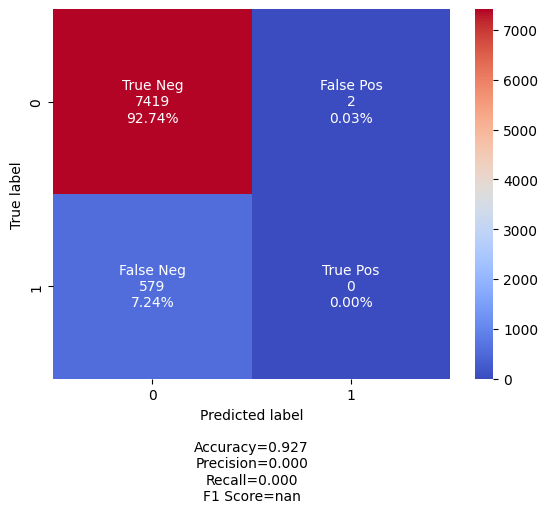

In [ ]:
# view confusion matrix
# the F1-score doesn't show but that's ok
cf_matrix_1=confusion_matrix(y_1_test,y_1_pred)
labels=['True Neg','False Pos','False Neg','True Pos']
make_confusion_matrix(cf=cf_matrix_1,
                      group_names=labels,
                      cmap='coolwarm')

In [ ]:
# view F1-score
creport=classification_report(y_test,y_1_pred)
print(creport)

              precision    recall  f1-score   support

          no       0.93      1.00      0.96      7421
         yes       0.00      0.00      0.00       579

    accuracy                           0.93      8000
   macro avg       0.46      0.50      0.48      8000
weighted avg       0.86      0.93      0.89      8000



Although we are able to get great accuracy for class 0 ('no'), we were not able to get a good accuracy for class 1 ('yes').

## Modeling: Layer 1

### Prepare Dataset for Modeling

Split data into training, validation, and testing sets:

In [268]:
data=pd.concat([X_1,y],axis=1)
data

age           job   marital  education default  balance housing loan  y
0       58    management   married   tertiary      no     2143     yes   no  0
1       44    technician    single  secondary      no       29     yes   no  0
2       33  entrepreneur   married  secondary      no        2     yes  yes  0
3       47   blue-collar   married    unknown      no     1506     yes   no  0
4       33       unknown    single    unknown      no        1      no   no  0
...    ...           ...       ...        ...     ...      ...     ...  ... ..
39995   53    technician   married   tertiary      no      395      no   no  0
39996   30    management    single   tertiary      no     3340      no   no  1
39997   54         admin  divorced  secondary      no      200      no   no  1
39998   34    management   married   tertiary      no     1047      no   no  0
39999   38    technician   married  secondary      no     1442     yes   no  0

[40000 rows x 9 columns]

Create function to speed up preparing data for modeling going forward:

In [269]:
cat_cols = list(X_1.select_dtypes(include='object').columns)
num_cols = list(X_1.select_dtypes(exclude='object').columns)

num_cols

['age', 'balance']

In [270]:
cat_cols

['job', 'marital', 'education', 'default', 'housing', 'loan']

### Define and Run Functions for Modeling

Define code for preprocessing, modeling, and evaluation:

In [274]:
classifier_map={
    'etc':ExtraTreeClassifier(random_state=seed),
    'xgb':XGBClassifier(random_state=seed),
    'dtc':DecisionTreeClassifier(random_state=seed),
    'rfc':RandomForestClassifier(random_state=seed),
    'lgb':LGBMClassifier(random_state=seed,verbose=-1),
    'lrx':LogisticRegression(random_state=seed)
}

In [206]:
# Step 1: Split the data into training and testing sets
def split_data(data, target_column_name, random_state,test_size=0.2):
    print('Defining X...')
    X = data.drop(columns=[target_column_name])
    assert not X.isnull().any().any(), "X contains NaN values!"

    print('Defining y...')
    y = data[target_column_name]
    assert not y.isnull().any(), "y contains NaN values!"
  
    print('train_test_splitting...')
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=test_size,random_state=random_state)
    
    assert X_train.shape[0] + X_test.shape[0] == X.shape[0], "Train and test sizes do not match!"   
    return X_train,X_test,y_train,y_test

# Step 2: Create a function to transform the data
def transform_data(X_train, X_test, cat_cols):
    # One-hot encoding for categorical variables
    print('X_train encoding...')
    X_train_encoded = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
    assert X_train_encoded.shape[1] > 0, "X_train_encoded has no columns!"

    print('X_test encoding...')
    X_test_encoded = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)
    
    # Align columns with the training set to avoid mismatches
    print('Aligning columns...')
    X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

    # Scaling
    scaler = StandardScaler()
    print('Scaling X_train...')
    X_train_scaled = scaler.fit_transform(X_train_encoded)
    print('Scaling X_test...')
    X_test_scaled = scaler.transform(X_test_encoded)

    # Convert scaled arrays back to DataFrame
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_encoded.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_encoded.columns)

    return X_train_scaled, X_test_scaled

# Step 3: Set up the RandomOverSampler
def oversample(X, y,random_state):
    ros = RandomOverSampler(random_state=random_state)
    print('Oversampling...')

    X_resampled, y_resampled = ros.fit_resample(X, y)

    # Convert resampled arrays back to DataFrame
    X_resampled = pd.DataFrame(X_resampled, columns=X.columns)

    # Assert to check if the resampling worked
    assert X_resampled.shape[0] > X.shape[0], "Oversampling did not increase the number of samples!"

    return X_resampled, y_resampled

# Step 4: Use 5-fold cross-validation and classification report
def evaluate_model(X_train, y_train, model,random_state):
    print(f'Evaluating model: {model}')
    
    # Initialize a StratifiedKFold object for cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    all_y_true = []
    all_y_pred = []

    for train_index, test_index in skf.split(X_train, y_train):
        X_cv_train, X_cv_test = X_train.iloc[train_index], X_train.iloc[test_index]
        y_cv_train, y_cv_test = y_train.iloc[train_index], y_train.iloc[test_index]

        # Fit the model on the training fold
        model.fit(X_cv_train, y_cv_train)
        
        # Make predictions on the validation fold
        y_cv_pred = model.predict(X_cv_test)

        # Collect the true and predicted values
        all_y_true.extend(y_cv_test)
        all_y_pred.extend(y_cv_pred)

        assert set(y_cv_test).issubset({0,1}),'y_cv_test contains unexpected values!'
    
    # Calculate evaluation metrics
    precision = precision_score(all_y_true, all_y_pred)
    recall = recall_score(all_y_true, all_y_pred)
    f1 = f1_score(all_y_true, all_y_pred)
    accuracy = accuracy_score(all_y_true, all_y_pred)

    results[model.__class__.__name__]={
        'precision':precision,
        'recall':recall,
        'f1_score':f1,
        'accuracy':accuracy
    }
    
    # Generate the classification report
    print(classification_report(all_y_true, all_y_pred))
    
    # Optionally: Calculate and print cross-validation scores
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"Cross-validation scores: {scores}")
    print(f"Mean score: {scores.mean()*100:.2f}%")
    
    assert len(all_y_true) == len(all_y_pred), "Mismatch between true and predicted values length!"

Defining X...
Defining y...
train_test_splitting...
X_train encoding...
X_test encoding...
Aligning columns...
Scaling X_train...
Scaling X_test...
Oversampling...

Evaluating etc on Train set:
Evaluating model: ExtraTreeClassifier(random_state=4769)
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     29690
           1       0.92      1.00      0.96     29690

    accuracy                           0.95     59380
   macro avg       0.96      0.95      0.95     59380
weighted avg       0.96      0.95      0.95     59380

Cross-validation scores: [0.95520377 0.95486696 0.95444594 0.95528798 0.95469855]
Mean score: 95.49%

Evaluating etc on Test set:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      7414
           1       0.13      0.17      0.15       586

    accuracy                           0.85      8000
   macro avg       0.53      0.54      0.53      8000
weighted avg       0

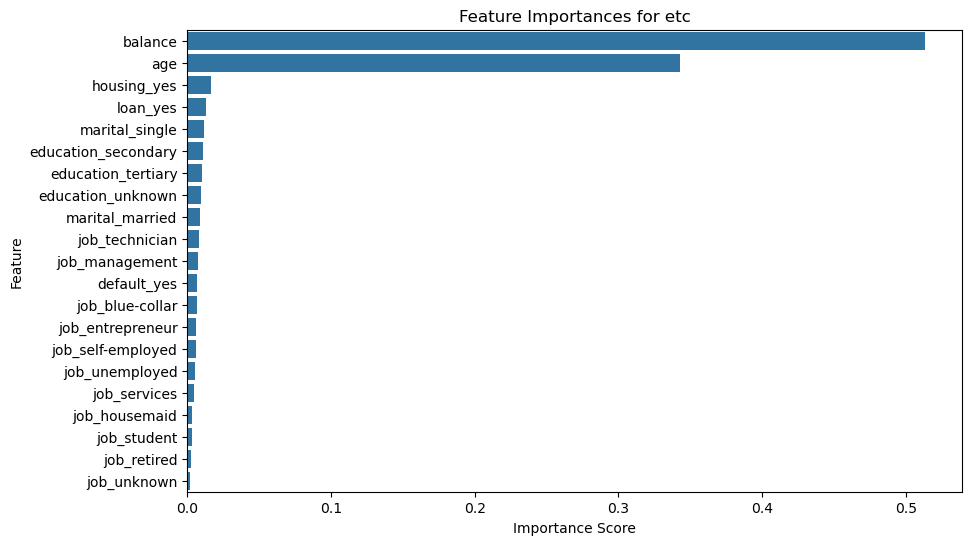


 ********************

Evaluating xgb on Train set:
Evaluating model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=4769, ...)
              precision    recall  f1-score   support

           0       0.81      0.76      0.78     29690
           1       0.77      0.83      0.80     29690

    acc

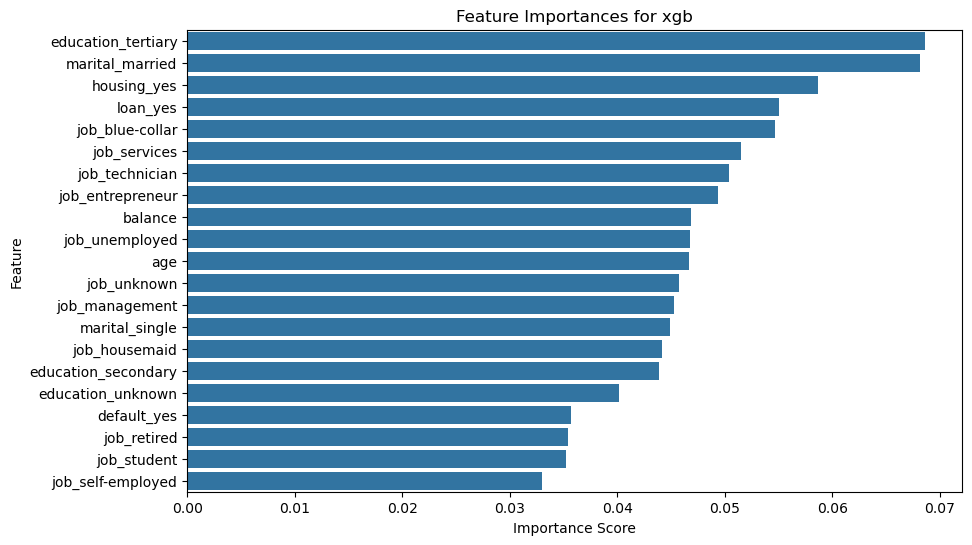


 ********************

Evaluating dtc on Train set:
Evaluating model: DecisionTreeClassifier(random_state=4769)
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     29690
           1       0.91      1.00      0.96     29690

    accuracy                           0.95     59380
   macro avg       0.96      0.95      0.95     59380
weighted avg       0.96      0.95      0.95     59380

Cross-validation scores: [0.95225665 0.95663523 0.95444594 0.95183563 0.95259347]
Mean score: 95.36%

Evaluating dtc on Test set:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      7414
           1       0.13      0.18      0.15       586

    accuracy                           0.85      8000
   macro avg       0.53      0.54      0.53      8000
weighted avg       0.87      0.85      0.86      8000



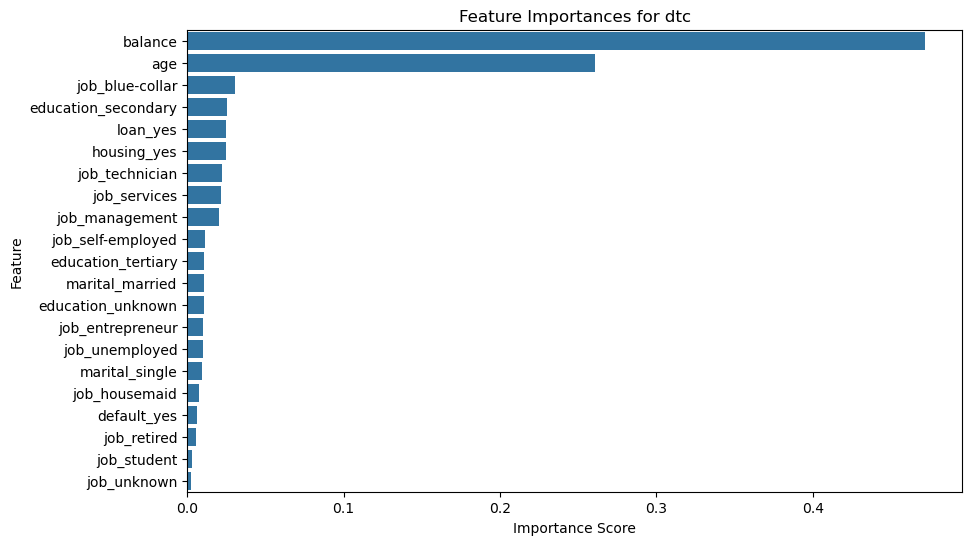


 ********************

Evaluating rfc on Train set:
Evaluating model: RandomForestClassifier(random_state=4769)
              precision    recall  f1-score   support

           0       1.00      0.93      0.97     29690
           1       0.94      1.00      0.97     29690

    accuracy                           0.97     59380
   macro avg       0.97      0.97      0.97     59380
weighted avg       0.97      0.97      0.97     59380

Cross-validation scores: [0.96699225 0.96833951 0.9682553  0.96522398 0.96589761]
Mean score: 96.69%

Evaluating rfc on Test set:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      7414
           1       0.15      0.15      0.15       586

    accuracy                           0.88      8000
   macro avg       0.54      0.54      0.54      8000
weighted avg       0.88      0.88      0.88      8000



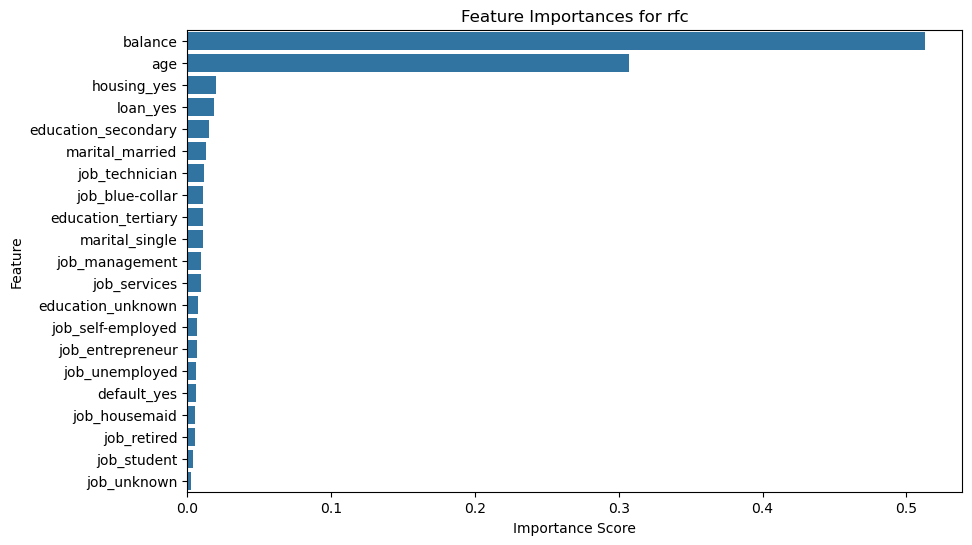


 ********************

Evaluating lgb on Train set:
Evaluating model: LGBMClassifier(random_state=4769, verbose=-1)
              precision    recall  f1-score   support

           0       0.73      0.71      0.72     29690
           1       0.72      0.74      0.73     29690

    accuracy                           0.73     59380
   macro avg       0.73      0.73      0.73     59380
weighted avg       0.73      0.73      0.73     59380

Cross-validation scores: [0.72027619 0.73400135 0.7181711  0.7304648  0.72212866]
Mean score: 72.50%

Evaluating lgb on Test set:
              precision    recall  f1-score   support

           0       0.94      0.70      0.80      7414
           1       0.11      0.47      0.18       586

    accuracy                           0.68      8000
   macro avg       0.53      0.58      0.49      8000
weighted avg       0.88      0.68      0.76      8000



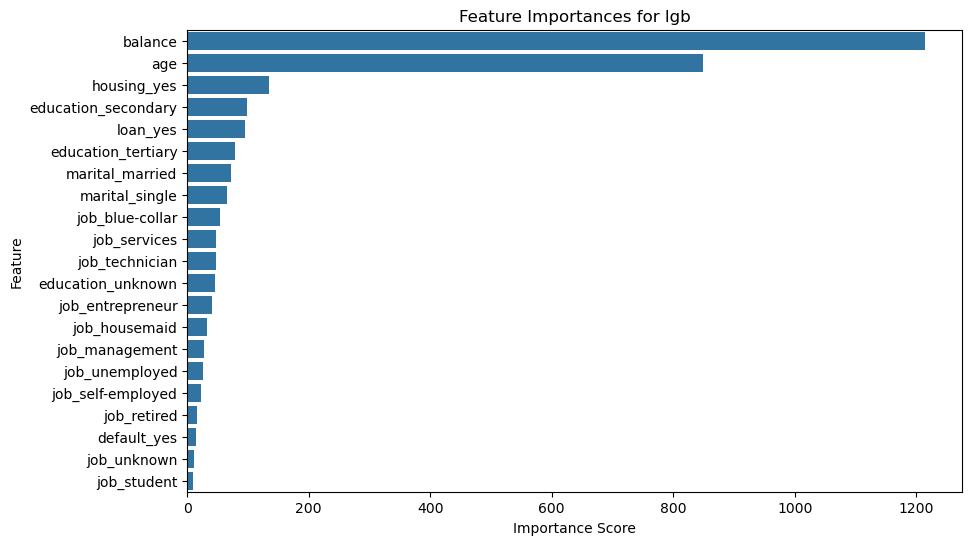


 ********************

Evaluating lrx on Train set:
Evaluating model: LogisticRegression(random_state=4769)
              precision    recall  f1-score   support

           0       0.58      0.61      0.59     29690
           1       0.59      0.55      0.57     29690

    accuracy                           0.58     59380
   macro avg       0.58      0.58      0.58     59380
weighted avg       0.58      0.58      0.58     59380

Cross-validation scores: [0.5784776  0.57999326 0.5808353  0.57957225 0.58428764]
Mean score: 58.06%

Evaluating lrx on Test set:
              precision    recall  f1-score   support

           0       0.95      0.61      0.74      7414
           1       0.10      0.55      0.17       586

    accuracy                           0.61      8000
   macro avg       0.52      0.58      0.46      8000
weighted avg       0.88      0.61      0.70      8000


 ********************
********************
Done!
********************


In [208]:
target_column_name='y'

# Splitting the data
X_train, X_test, y_train, y_test = split_data(data, target_column_name,random_state=seed)

# Transforming the data
X_train_scaled, X_test_scaled = transform_data(X_train, X_test, cat_cols)

# Oversampling the training data
X_train_resampled, y_train_resampled = oversample(X_train_scaled, y_train,random_state=seed)

results={}

for model_name, model in classifier_map.items():
    # Evaluate the model using cross-validation
    print(f'\nEvaluating {model_name} on Train set:')
    evaluate_model(X_train_resampled, y_train_resampled, model, random_state=seed)
    
    # Final evaluation on test set
    print(f'\nEvaluating {model_name} on Test set:')
    y_test_pred=model.predict(X_test_scaled)
    print(classification_report(y_test,y_test_pred))
    
    # Feature importance
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_names = X_train_resampled.columns  # Now this will work correctly
        feature_importances_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        })
        
        # Sort DataFrame by importance
        feature_importances_df.sort_values(by='Importance', ascending=False, inplace=True)
        
        # Plot feature importances
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=feature_importances_df)
        plt.title(f'Feature Importances for {model_name}')
        plt.xlabel('Importance Score')
        plt.ylabel('Feature')
        plt.show()
        
    print('\n', '*' * 20)
    
print('*'*20)
print('Done!')
print('*'*20)

This is a good first step - we have classification reports for a suite of algorithms, along with the extracted feature importances for the models that support this feature. After completing this survey, we found that the `RandomForestClassifier` and `LGBMClassifier` performed the best.

Now we can evaluate the RFC model on the test set:

In [212]:
best_model=classifier_map['rfc']
best_model.fit(X_train_resampled,y_train_resampled)
y_test_pred=best_model.predict(X_test_scaled)
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      7414
           1       0.15      0.12      0.13       586

    accuracy                           0.89      8000
   macro avg       0.54      0.53      0.54      8000
weighted avg       0.87      0.89      0.88      8000



In [226]:
best_model=classifier_map['lgb']
best_model.fit(X_train_resampled,y_train_resampled)
y_test_pred=best_model.predict(X_test_scaled)
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.69      0.79      7421
           1       0.07      0.29      0.11       579

    accuracy                           0.66      8000
   macro avg       0.50      0.49      0.45      8000
weighted avg       0.86      0.66      0.74      8000



In [213]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [215]:
model=BalancedRandomForestClassifier(random_state=seed,sampling_strategy='all',replacement=True,bootstrap=False)
model.fit(X_train_resampled,y_train_resampled)
y_test_pred=model.predict(X_test_scaled)
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      7414
           1       0.15      0.12      0.13       586

    accuracy                           0.89      8000
   macro avg       0.54      0.53      0.54      8000
weighted avg       0.87      0.89      0.88      8000



### Optuna with `LGBMClassifier`

In [241]:
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0)
}

In [248]:
times={}
results={}
n_trials=1000

In [249]:
target_column_name='y'

# Splitting the data
X_train, X_test, y_train, y_test = split_data(data, target_column_name,random_state=seed)

# Transforming the data
X_train_scaled, X_test_scaled = transform_data(X_train, X_test, cat_cols)

# Oversampling the training data
X_train_resampled, y_train_resampled = oversample(X_train_scaled, y_train,random_state=seed)

print('Done!')

X_train encoding...
X_test encoding...
Aligning columns...
Scaling X_train...
Scaling X_test...
Oversampling...
Done!


In [250]:
start_time = time.time()

def objective(trial):
    # Classifier definition
    boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'rf'])
    
    # Conditional parameters for random forest
    if boosting_type == 'rf':
        bagging_fraction = trial.suggest_float('bagging_fraction', 0.1, 1.0)  # Only for random forest
        bagging_freq = trial.suggest_int('bagging_freq', 1, 10)  # greater than 0
        subsample = 1.0  # Subsample is not used with random forest
    else:
        subsample = trial.suggest_float('subsample', 1E-2, 1E0, log=True)  # For gbdt or dart
        bagging_fraction = None  # bagging_fraction not used for gbdt or dart
        bagging_freq = 0  # bagging_freq not used for gbdt or dart

    # Define classifier with updated parameters
    classifier = LGBMClassifier(
        min_child_samples=trial.suggest_int('min_child_samples', 5, 250),
        verbose=trial.suggest_categorical('verbose', [-1]),
        boosting_type=boosting_type,
        num_leaves=trial.suggest_int('num_leaves', 10, 500),
        learning_rate=trial.suggest_float('learning_rate', 1E-4, 1E0, log=True),
        n_estimators=trial.suggest_int('n_estimators', 50, 1000),
        max_depth=trial.suggest_int('max_depth', 1, 5),
        subsample=subsample,  # Conditional subsample
        colsample_bytree=trial.suggest_float('colsample_bytree', 1E-2, 1E0, log=True),
        random_state=trial.suggest_categorical('random_state', [seed]),
        n_jobs=trial.suggest_categorical('n_jobs', [-1]),
        reg_alpha=trial.suggest_float('reg_alpha', 1E-3, 1E2, log=True),
        reg_lambda=trial.suggest_float('reg_lambda', 1E-3, 1E2, log=True),
        importance_type=trial.suggest_categorical('importance_type', ['split', 'gain']),
        bagging_fraction=bagging_fraction,  # Conditional bagging fraction
        bagging_freq=bagging_freq  # Conditional bagging frequency
    )

    # Define cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    
    # Cross-validation to evaluate the model
    scores = cross_validate(
        classifier, 
        X_train_resampled, 
        y_train_resampled, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring,
        verbose=0
    )
    
    return scores['test_accuracy'].mean()

# Usage with Optuna study
lgb = optuna.create_study(direction='maximize')
lgb.optimize(objective, n_trials=n_trials * 3)  # because more parameters

# Record time
end_time = time.time()
elapsed_time = end_time - start_time

# Store results and times
times['lgb'] = {
    'start_time_lgb': start_time,
    'end_time_lgb': end_time,
    'elapsed_time_lgb': elapsed_time
}
results['lgb'] = lgb.best_params

print('Done!')

[I 2024-10-25 17:11:31,457] A new study created in memory with name: no-name-b31636a9-f894-44d7-9948-734b2dfe3c22
[I 2024-10-25 17:11:56,441] Trial 0 finished with value: 0.5869521267278744 and parameters: {'boosting_type': 'dart', 'subsample': 0.05831390996794807, 'min_child_samples': 25, 'verbose': -1, 'num_leaves': 171, 'learning_rate': 0.00012243631795037715, 'n_estimators': 914, 'max_depth': 4, 'colsample_bytree': 0.0885219053444532, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.23199470749476706, 'reg_lambda': 57.499595298796, 'importance_type': 'split'}. Best is trial 0 with value: 0.5869521267278744.
[I 2024-10-25 17:11:57,590] Trial 1 finished with value: 0.582235602465093 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.8554636319048117, 'min_child_samples': 77, 'verbose': -1, 'num_leaves': 20, 'learning_rate': 0.0036878394894859956, 'n_estimators': 273, 'max_depth': 3, 'colsample_bytree': 0.011700342380459366, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.0

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7764614618223333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7764614618223333
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.9671126337983471, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9671126337983471
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq

[I 2024-10-25 17:40:22,827] Trial 327 finished with value: 0.5853686141953667 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.26420189548430784, 'bagging_freq': 4, 'min_child_samples': 5, 'verbose': -1, 'num_leaves': 432, 'learning_rate': 0.45056127052694367, 'n_estimators': 918, 'max_depth': 5, 'colsample_bytree': 0.06849334366361734, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.2267841270039745, 'reg_lambda': 0.0010264516861093914, 'importance_type': 'gain'}. Best is trial 262 with value: 0.9515885196256416.
[I 2024-10-25 17:40:25,553] Trial 328 finished with value: 0.9243170176717687 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10894721057978153, 'min_child_samples': 18, 'verbose': -1, 'num_leaves': 275, 'learning_rate': 0.6452309476970157, 'n_estimators': 889, 'max_depth': 5, 'colsample_bytree': 0.7891754058852322, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.14640067997708925, 'reg_lambda': 4.638030721848832, 'importance_type': 'gain'}. Best i

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7764614618223333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7764614618223333
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.9671126337983471, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9671126337983471
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.13055828370

[I 2024-10-25 17:40:39,273] Trial 333 finished with value: 0.700164958147752 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15009041618449026, 'min_child_samples': 14, 'verbose': -1, 'num_leaves': 274, 'learning_rate': 0.6480904908068107, 'n_estimators': 869, 'max_depth': 5, 'colsample_bytree': 0.07915384833154099, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.17863180199909195, 'reg_lambda': 0.0023904297402599127, 'importance_type': 'gain'}. Best is trial 262 with value: 0.9515885196256416.
[I 2024-10-25 17:40:41,963] Trial 334 finished with value: 0.9309369182729903 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13088741834814127, 'min_child_samples': 9, 'verbose': -1, 'num_leaves': 281, 'learning_rate': 0.5507716952937791, 'n_estimators': 833, 'max_depth': 5, 'colsample_bytree': 0.7847743103952548, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.2447824974863626, 'reg_lambda': 0.0029433011869868225, 'importance_type': 'gain'}. Best is trial 262 with value

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7764614618223333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7764614618223333
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.9671126337983471, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9671126337983471
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq

[I 2024-10-25 17:40:51,494] Trial 337 finished with value: 0.9366809669927513 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09813240977833114, 'min_child_samples': 10, 'verbose': -1, 'num_leaves': 355, 'learning_rate': 0.7730235229101707, 'n_estimators': 861, 'max_depth': 5, 'colsample_bytree': 0.6777459193609209, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.18276739931320696, 'reg_lambda': 0.0016924301566647025, 'importance_type': 'gain'}. Best is trial 262 with value: 0.9515885196256416.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7764614618223333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7764614618223333
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.9671126337983471, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9671126337983471
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.13055828370

[I 2024-10-25 17:40:53,972] Trial 338 finished with value: 0.9395782630220136 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1259111555857188, 'min_child_samples': 5, 'verbose': -1, 'num_leaves': 261, 'learning_rate': 0.6489353238359526, 'n_estimators': 796, 'max_depth': 5, 'colsample_bytree': 0.8159393942518086, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.2652283217706942, 'reg_lambda': 0.00322782748409603, 'importance_type': 'gain'}. Best is trial 262 with value: 0.9515885196256416.
[I 2024-10-25 17:40:56,538] Trial 339 finished with value: 0.9339016167697316 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1278286992896055, 'min_child_samples': 14, 'verbose': -1, 'num_leaves': 259, 'learning_rate': 0.602824166741096, 'n_estimators': 801, 'max_depth': 5, 'colsample_bytree': 0.7943455577805798, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.2104376132447343, 'reg_lambda': 0.0036077200013099977, 'importance_type': 'gain'}. Best is trial 262 with value: 0.95

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7764614618223333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7764614618223333
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.75214662511201, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75214662511201
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 w

[I 2024-10-25 17:41:17,952] Trial 347 finished with value: 0.938769690186272 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1741653414218125, 'min_child_samples': 5, 'verbose': -1, 'num_leaves': 261, 'learning_rate': 0.6111806767258445, 'n_estimators': 748, 'max_depth': 5, 'colsample_bytree': 0.837308182991872, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.11130115784310418, 'reg_lambda': 0.0024425063383934566, 'importance_type': 'gain'}. Best is trial 262 with value: 0.9515885196256416.
[I 2024-10-25 17:41:20,473] Trial 348 finished with value: 0.9264731334022821 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1769522929578875, 'min_child_samples': 13, 'verbose': -1, 'num_leaves': 248, 'learning_rate': 0.5232663558116954, 'n_estimators': 801, 'max_depth': 5, 'colsample_bytree': 0.741773363643515, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.10956276574778195, 'reg_lambda': 0.0036438665259107975, 'importance_type': 'gain'}. Best is trial 262 with value: 0.

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.9671126337983471, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9671126337983471
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagg

[I 2024-10-25 17:41:27,735] Trial 350 finished with value: 0.8625476087026869 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15454597384718016, 'min_child_samples': 13, 'verbose': -1, 'num_leaves': 257, 'learning_rate': 0.4753701821090589, 'n_estimators': 746, 'max_depth': 4, 'colsample_bytree': 0.8357916923559617, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.16704758487386873, 'reg_lambda': 0.0025380968677340696, 'importance_type': 'gain'}. Best is trial 262 with value: 0.9515885196256416.
[I 2024-10-25 17:41:31,425] Trial 351 finished with value: 0.9189772333809444 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.21501807184201369, 'min_child_samples': 19, 'verbose': -1, 'num_leaves': 471, 'learning_rate': 0.5975963529087622, 'n_estimators': 868, 'max_depth': 5, 'colsample_bytree': 0.6142919128454057, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.10093320834288047, 'reg_lambda': 0.005299213087926751, 'importance_type': 'gain'}. Best is trial 262 with valu

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.13055828370900574, subsample=1.0 will be ignored. Current value: bagging_fraction=0.13055828370900574
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.75214662511201, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75214662511201
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0

[I 2024-10-25 17:42:00,204] Trial 362 finished with value: 0.9406226579568356 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.011658146232910017, 'min_child_samples': 16, 'verbose': -1, 'num_leaves': 247, 'learning_rate': 0.5427116733385589, 'n_estimators': 925, 'max_depth': 5, 'colsample_bytree': 0.9166431637254526, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.12387330240983692, 'reg_lambda': 0.005785177692433492, 'importance_type': 'gain'}. Best is trial 262 with value: 0.9515885196256416.
[I 2024-10-25 17:42:04,051] Trial 363 finished with value: 0.607923786240264 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.011185710920856013, 'min_child_samples': 23, 'verbose': -1, 'num_leaves': 243, 'learning_rate': 0.0007680943310509797, 'n_estimators': 910, 'max_depth': 5, 'colsample_bytree': 0.9270727916129679, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.12076120254189966, 'reg_lambda': 0.006546275539403086, 'importance_type': 'gain'}. Best is trial 262 with v

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-25 17:56:16,702] Trial 544 finished with value: 0.942172342996562 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.03999298284517087, 'min_child_samples': 23, 'verbose': -1, 'num_leaves': 126, 'learning_rate': 0.9951989993170547, 'n_estimators': 980, 'max_depth': 5, 'colsample_bytree': 0.6725304479940551, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.002046751481402993, 'reg_lambda': 0.08088197390866336, 'importance_type': 'gain'}. Best is trial 262 with value: 0.9515885196256416.
[I 2024-10-25 17:56:20,782] Trial 545 finished with value: 0.6029882450987623 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.03672342965117867, 'min_child_samples': 22, 'verbose': -1, 'num_leaves': 115, 'learning_rate': 0.0003139676400460615, 'n_estimators': 968, 'max_depth': 5, 'colsample_bytree': 0.8148583268353708, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.001214731664789479, 'reg_lambda': 0.04789969275486845, 'importance_type': 'gain'}. Best is trial 262 with val

[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.8026715804708219, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8026715804708219
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: ba

[I 2024-10-25 17:56:51,245] Trial 554 finished with value: 0.6145097841607352 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.032020828399916726, 'min_child_samples': 33, 'verbose': -1, 'num_leaves': 112, 'learning_rate': 0.9812832171601484, 'n_estimators': 980, 'max_depth': 5, 'colsample_bytree': 0.019815190333679955, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.001305851670134515, 'reg_lambda': 0.05386101252605756, 'importance_type': 'gain'}. Best is trial 262 with value: 0.9515885196256416.
[I 2024-10-25 17:56:52,258] Trial 555 finished with value: 0.6044874009861342 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.02809207459849164, 'min_child_samples': 27, 'verbose': -1, 'num_leaves': 98, 'learning_rate': 0.0023271603914219686, 'n_estimators': 187, 'max_depth': 5, 'colsample_bytree': 0.7849081297538579, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.0010237053090746578, 'reg_lambda': 0.08483329885484676, 'importance_type': 'gain'}. Best is trial 262 with

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-25 17:56:55,277] Trial 556 finished with value: 0.9475120861467996 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.032331410397260715, 'min_child_samples': 33, 'verbose': -1, 'num_leaves': 145, 'learning_rate': 0.9875735583585533, 'n_estimators': 952, 'max_depth': 5, 'colsample_bytree': 0.8813869756188719, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.0015483072866076535, 'reg_lambda': 0.041150061655047476, 'importance_type': 'gain'}. Best is trial 262 with value: 0.9515885196256416.
[I 2024-10-25 17:56:58,537] Trial 557 finished with value: 0.9308021814327965 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.03462324258680232, 'min_child_samples': 28, 'verbose': -1, 'num_leaves': 128, 'learning_rate': 0.7397889851469701, 'n_estimators': 936, 'max_depth': 5, 'colsample_bytree': 0.6546606538582509, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.002119723961180118, 'reg_lambda': 0.06207101735298957, 'importance_type': 'gain'}. Best is trial 262 with va

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-25 17:57:04,343] Trial 559 finished with value: 0.6143244912140091 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.028789136398975644, 'min_child_samples': 39, 'verbose': -1, 'num_leaves': 109, 'learning_rate': 0.9970409124225917, 'n_estimators': 962, 'max_depth': 5, 'colsample_bytree': 0.043504197828368354, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.0010062069578956271, 'reg_lambda': 0.033025116532211754, 'importance_type': 'gain'}. Best is trial 262 with value: 0.9515885196256416.
[I 2024-10-25 17:57:07,061] Trial 560 finished with value: 0.7030285713856069 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.034409981364798246, 'min_child_samples': 25, 'verbose': -1, 'num_leaves': 138, 'learning_rate': 0.7546469002617393, 'n_estimators': 934, 'max_depth': 5, 'colsample_bytree': 0.09329220338229857, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.001595656622462416, 'reg_lambda': 0.053277437786657555, 'importance_type': 'gain'}. Best is trial 262 wi

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-25 17:57:10,024] Trial 561 finished with value: 0.9419196731178937 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.04934386648698799, 'min_child_samples': 34, 'verbose': -1, 'num_leaves': 148, 'learning_rate': 0.8227789255998104, 'n_estimators': 985, 'max_depth': 5, 'colsample_bytree': 0.8112557887691527, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.001281063387115414, 'reg_lambda': 0.03790327869472723, 'importance_type': 'gain'}. Best is trial 262 with value: 0.9515885196256416.
[I 2024-10-25 17:57:12,917] Trial 562 finished with value: 0.9430314123559171 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.04264324253029951, 'min_child_samples': 30, 'verbose': -1, 'num_leaves': 125, 'learning_rate': 0.730987544623272, 'n_estimators': 959, 'max_depth': 5, 'colsample_bytree': 0.8932087555177094, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.0022294289225065363, 'reg_lambda': 0.06764066460485466, 'importance_type': 'gain'}. Best is trial 262 with value

[LightGBM] [Warning] bagging_fraction is set=0.8026715804708219, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8026715804708219
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagg

[I 2024-10-25 17:57:15,869] Trial 563 finished with value: 0.9506283281227361 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0369919988059672, 'min_child_samples': 21, 'verbose': -1, 'num_leaves': 87, 'learning_rate': 0.9987775074394877, 'n_estimators': 945, 'max_depth': 5, 'colsample_bytree': 0.8962181196960457, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.0017339308615318297, 'reg_lambda': 0.0868294322520656, 'importance_type': 'gain'}. Best is trial 262 with value: 0.9515885196256416.
[I 2024-10-25 17:57:18,911] Trial 564 finished with value: 0.9490618066525492 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.030781001980661745, 'min_child_samples': 22, 'verbose': -1, 'num_leaves': 93, 'learning_rate': 0.8531012125274681, 'n_estimators': 951, 'max_depth': 5, 'colsample_bytree': 0.8991117299106794, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.0019222901436359286, 'reg_lambda': 0.10108924722865842, 'importance_type': 'gain'}. Best is trial 262 with value:

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-25 17:58:25,914] Trial 582 finished with value: 0.8928848589461647 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.030955801700455653, 'min_child_samples': 178, 'verbose': -1, 'num_leaves': 124, 'learning_rate': 0.665492042996035, 'n_estimators': 981, 'max_depth': 5, 'colsample_bytree': 0.9046870647756019, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.0037634654711286393, 'reg_lambda': 0.26438606587988245, 'importance_type': 'gain'}. Best is trial 262 with value: 0.9515885196256416.
[I 2024-10-25 17:58:28,863] Trial 583 finished with value: 0.9486406632339245 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.37142210876818266, 'min_child_samples': 20, 'verbose': -1, 'num_leaves': 140, 'learning_rate': 0.8269244728737567, 'n_estimators': 949, 'max_depth': 5, 'colsample_bytree': 0.9154505118065244, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.0018722107044598937, 'reg_lambda': 0.34017141700906023, 'importance_type': 'gain'}. Best is trial 262 with va

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-25 17:59:45,145] Trial 605 finished with value: 0.949466086686536 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.028466587387758275, 'min_child_samples': 19, 'verbose': -1, 'num_leaves': 142, 'learning_rate': 0.6964702153800947, 'n_estimators': 999, 'max_depth': 5, 'colsample_bytree': 0.9336455368674204, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.0010291046274647781, 'reg_lambda': 0.05655699323022972, 'importance_type': 'gain'}. Best is trial 604 with value: 0.9525991835352648.
[I 2024-10-25 17:59:48,221] Trial 606 finished with value: 0.9480342665905196 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.028559642130341727, 'min_child_samples': 19, 'verbose': -1, 'num_leaves': 145, 'learning_rate': 0.6244408473073156, 'n_estimators': 999, 'max_depth': 5, 'colsample_bytree': 0.9899456494447569, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.0011455411335421668, 'reg_lambda': 0.06073013938710431, 'importance_type': 'gain'}. Best is trial 604 with va

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-25 18:13:10,826] Trial 661 finished with value: 0.9443284005627977 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.022407962027884865, 'min_child_samples': 15, 'verbose': -1, 'num_leaves': 156, 'learning_rate': 0.5320234107001902, 'n_estimators': 955, 'max_depth': 5, 'colsample_bytree': 0.9848557325930223, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.001211554588998645, 'reg_lambda': 0.025459105704560486, 'importance_type': 'gain'}. Best is trial 604 with value: 0.9525991835352648.
[I 2024-10-25 18:13:14,007] Trial 662 finished with value: 0.9395782374864771 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.023390315359561382, 'min_child_samples': 14, 'verbose': -1, 'num_leaves': 432, 'learning_rate': 0.45472627197578985, 'n_estimators': 955, 'max_depth': 5, 'colsample_bytree': 0.9937413436079185, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.004555225441399486, 'reg_lambda': 0.024074529223495383, 'importance_type': 'gain'}. Best is trial 604 with 

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.716107295062776, subsample=1.0 will be ignored. Current value: bagging_fraction=0.716107295062776
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: baggin

[I 2024-10-25 18:27:10,563] Trial 701 finished with value: 0.8859112216497202 and parameters: {'boosting_type': 'dart', 'subsample': 0.020283737707869898, 'min_child_samples': 18, 'verbose': -1, 'num_leaves': 105, 'learning_rate': 0.6914972726793165, 'n_estimators': 945, 'max_depth': 5, 'colsample_bytree': 0.9162845839208157, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.0018162086818027058, 'reg_lambda': 0.04304321000882612, 'importance_type': 'gain'}. Best is trial 604 with value: 0.9525991835352648.
[I 2024-10-25 18:27:12,194] Trial 702 finished with value: 0.8329854669742451 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.030081577493891922, 'min_child_samples': 32, 'verbose': -1, 'num_leaves': 150, 'learning_rate': 0.5083166518778118, 'n_estimators': 923, 'max_depth': 5, 'colsample_bytree': 0.7906138447005944, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 4.972989287222551, 'reg_lambda': 0.018825197245944406, 'importance_type': 'gain'}. Best is trial 604 with valu

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9391506937392438, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9391506937392438
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagg

[I 2024-10-25 18:33:10,207] Trial 718 finished with value: 0.9065963880465826 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0250606376218617, 'min_child_samples': 13, 'verbose': -1, 'num_leaves': 173, 'learning_rate': 0.7240705265844626, 'n_estimators': 955, 'max_depth': 4, 'colsample_bytree': 0.9112908888304262, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.0010098502770254304, 'reg_lambda': 0.01843140212747456, 'importance_type': 'gain'}. Best is trial 703 with value: 0.9540478343871779.
[I 2024-10-25 18:33:13,092] Trial 719 finished with value: 0.9481184983952546 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.025674226959230613, 'min_child_samples': 16, 'verbose': -1, 'num_leaves': 169, 'learning_rate': 0.8593597252435355, 'n_estimators': 942, 'max_depth': 5, 'colsample_bytree': 0.747601129869731, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.0013859283280934689, 'reg_lambda': 0.025498052578454288, 'importance_type': 'gain'}. Best is trial 703 with val

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-25 18:39:07,479] Trial 724 finished with value: 0.892430078132642 and parameters: {'boosting_type': 'dart', 'subsample': 0.03113859687554448, 'min_child_samples': 16, 'verbose': -1, 'num_leaves': 158, 'learning_rate': 0.8347117813187638, 'n_estimators': 971, 'max_depth': 5, 'colsample_bytree': 0.7994719526815393, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.0010008233601195519, 'reg_lambda': 0.0330864631860345, 'importance_type': 'gain'}. Best is trial 723 with value: 0.9541320236326852.
[I 2024-10-25 18:39:13,334] Trial 725 finished with value: 0.8654280853251797 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.03321087256481591, 'min_child_samples': 17, 'verbose': -1, 'num_leaves': 160, 'learning_rate': 0.8405247186018326, 'n_estimators': 967, 'max_depth': 5, 'colsample_bytree': 0.2797194568613535, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.0020964817955363207, 'reg_lambda': 0.030761739720221892, 'importance_type': 'gain'}. Best is trial 723 with valu

[LightGBM] [Warning] bagging_fraction is set=0.716107295062776, subsample=1.0 will be ignored. Current value: bagging_fraction=0.716107295062776
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: baggin

[I 2024-10-25 18:44:54,793] Trial 764 finished with value: 0.9550753219594933 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.029833534086923956, 'min_child_samples': 10, 'verbose': -1, 'num_leaves': 179, 'learning_rate': 0.9912428083997843, 'n_estimators': 971, 'max_depth': 5, 'colsample_bytree': 0.9049503189277431, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.002667057720416802, 'reg_lambda': 0.025172007536141464, 'importance_type': 'gain'}. Best is trial 764 with value: 0.9550753219594933.
[I 2024-10-25 18:44:57,987] Trial 765 finished with value: 0.8653423270628128 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.02646635894355774, 'min_child_samples': 9, 'verbose': -1, 'num_leaves': 183, 'learning_rate': 0.8499804707945507, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.9166187872787359, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.0033884385470689025, 'reg_lambda': 0.0245774807198338, 'importance_type': 'gain'}. Best is trial 764 with valu

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-25 18:48:36,249] Trial 804 finished with value: 0.6140044585898077 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.03564597808959508, 'min_child_samples': 5, 'verbose': -1, 'num_leaves': 169, 'learning_rate': 0.8424696413138495, 'n_estimators': 926, 'max_depth': 5, 'colsample_bytree': 0.05052816354921686, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.0018880135283312924, 'reg_lambda': 0.013845770625067439, 'importance_type': 'gain'}. Best is trial 764 with value: 0.9550753219594933.
[I 2024-10-25 18:48:39,632] Trial 805 finished with value: 0.9542330776814714 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.03348503116654856, 'min_child_samples': 16, 'verbose': -1, 'num_leaves': 158, 'learning_rate': 0.9941032230691987, 'n_estimators': 981, 'max_depth': 5, 'colsample_bytree': 0.9923900924776465, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.0024238225343923025, 'reg_lambda': 0.018383652925102127, 'importance_type': 'gain'}. Best is trial 764 with v

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-25 18:49:13,904] Trial 814 finished with value: 0.594532153574519 and parameters: {'boosting_type': 'dart', 'subsample': 0.0486493298161774, 'min_child_samples': 13, 'verbose': -1, 'num_leaves': 202, 'learning_rate': 0.8633806667443804, 'n_estimators': 904, 'max_depth': 1, 'colsample_bytree': 0.9197925899825266, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.003014694664825346, 'reg_lambda': 0.014266188621684595, 'importance_type': 'gain'}. Best is trial 764 with value: 0.9550753219594933.
[I 2024-10-25 18:49:17,301] Trial 815 finished with value: 0.9452549035997319 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.05778834556319869, 'min_child_samples': 17, 'verbose': -1, 'num_leaves': 195, 'learning_rate': 0.8488282496430843, 'n_estimators': 907, 'max_depth': 5, 'colsample_bytree': 0.7846873377821273, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.0036287168748501287, 'reg_lambda': 0.010408623778112818, 'importance_type': 'gain'}. Best is trial 764 with valu

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9391506937392438, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9391506937392438
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagg

[I 2024-10-25 19:04:02,399] Trial 977 finished with value: 0.8671616772994513 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.03351178732457133, 'min_child_samples': 9, 'verbose': -1, 'num_leaves': 198, 'learning_rate': 0.9975908222617906, 'n_estimators': 874, 'max_depth': 5, 'colsample_bytree': 0.7068781467004748, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.002071739625114824, 'reg_lambda': 0.012626858995667825, 'importance_type': 'gain'}. Best is trial 966 with value: 0.9561365561620576.
[I 2024-10-25 19:04:04,770] Trial 978 finished with value: 0.869183125703176 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.035992824374874235, 'min_child_samples': 10, 'verbose': -1, 'num_leaves': 206, 'learning_rate': 0.8629074352701305, 'n_estimators': 858, 'max_depth': 5, 'colsample_bytree': 0.7855844505326103, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.0022351805019736426, 'reg_lambda': 0.014273832807521397, 'importance_type': 'gain'}. Best is trial 966 with val

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.15826678741996086, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15826678741996086
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: ba

[I 2024-10-25 19:08:15,553] Trial 1027 finished with value: 0.6657344564373038 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0409238261029633, 'min_child_samples': 211, 'verbose': -1, 'num_leaves': 170, 'learning_rate': 0.022449012361428558, 'n_estimators': 919, 'max_depth': 5, 'colsample_bytree': 0.8562851849025557, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.009268731422436042, 'reg_lambda': 0.008694734993776642, 'importance_type': 'gain'}. Best is trial 966 with value: 0.9561365561620576.
[I 2024-10-25 19:08:18,145] Trial 1028 finished with value: 0.9521949162690465 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.03487167282922103, 'min_child_samples': 14, 'verbose': -1, 'num_leaves': 180, 'learning_rate': 0.9971479744060138, 'n_estimators': 903, 'max_depth': 5, 'colsample_bytree': 0.9223411622371201, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.00472386613928437, 'reg_lambda': 0.02314724960204593, 'importance_type': 'gain'}. Best is trial 966 with v

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-25 19:08:26,132] Trial 1032 finished with value: 0.7727318630623937 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.05216266670356431, 'min_child_samples': 9, 'verbose': -1, 'num_leaves': 149, 'learning_rate': 0.9989888404051375, 'n_estimators': 77, 'max_depth': 5, 'colsample_bytree': 0.8508522948571214, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.006925272197234486, 'reg_lambda': 0.006894907368495998, 'importance_type': 'gain'}. Best is trial 966 with value: 0.9561365561620576.
[I 2024-10-25 19:08:28,049] Trial 1033 finished with value: 0.6133474774670523 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.04447215402582916, 'min_child_samples': 14, 'verbose': -1, 'num_leaves': 209, 'learning_rate': 0.7245503328446786, 'n_estimators': 844, 'max_depth': 5, 'colsample_bytree': 0.048122730192210285, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.00205408508602846, 'reg_lambda': 0.012761216016592192, 'importance_type': 'gain'}. Best is trial 966 with va

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-25 19:25:02,466] Trial 1206 finished with value: 0.6001583217455198 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.3995825538022473, 'bagging_freq': 1, 'min_child_samples': 216, 'verbose': -1, 'num_leaves': 212, 'learning_rate': 0.9851714745485238, 'n_estimators': 949, 'max_depth': 5, 'colsample_bytree': 0.7858813059835986, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.00299782002064192, 'reg_lambda': 0.028627450410589145, 'importance_type': 'gain'}. Best is trial 1128 with value: 0.9564060312610863.
[I 2024-10-25 19:25:05,105] Trial 1207 finished with value: 0.9556817483943574 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.022371615940407246, 'min_child_samples': 5, 'verbose': -1, 'num_leaves': 212, 'learning_rate': 0.853549836633964, 'n_estimators': 950, 'max_depth': 5, 'colsample_bytree': 0.997308120865226, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.0035552421348967853, 'reg_lambda': 0.025030851127016644, 'importance_type': 'gain'}. B

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-25 19:29:39,621] Trial 1259 finished with value: 0.9467540977904086 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.02657060799509606, 'min_child_samples': 9, 'verbose': -1, 'num_leaves': 196, 'learning_rate': 0.5620463505874902, 'n_estimators': 931, 'max_depth': 5, 'colsample_bytree': 0.9988856367223597, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.002509206170749606, 'reg_lambda': 0.01945415927406844, 'importance_type': 'gain'}. Best is trial 1128 with value: 0.9564060312610863.
[I 2024-10-25 19:30:54,446] Trial 1260 finished with value: 0.9011724386271466 and parameters: {'boosting_type': 'dart', 'subsample': 0.01684041689216131, 'min_child_samples': 5, 'verbose': -1, 'num_leaves': 219, 'learning_rate': 0.9941929111387238, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.6965964294833342, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.0047148589277060966, 'reg_lambda': 0.0051846965965866515, 'importance_type': 'gain'}. Best is trial 1128 with 

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-25 19:31:23,328] Trial 1271 finished with value: 0.937472673606573 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.026952057774537207, 'min_child_samples': 13, 'verbose': -1, 'num_leaves': 207, 'learning_rate': 0.8143129471349204, 'n_estimators': 967, 'max_depth': 5, 'colsample_bytree': 0.7468373710368904, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.008321539123067613, 'reg_lambda': 3.09074698495665, 'importance_type': 'gain'}. Best is trial 1128 with value: 0.9564060312610863.
[I 2024-10-25 19:31:28,032] Trial 1272 finished with value: 0.6037294424212025 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.6237684615119969, 'bagging_freq': 5, 'min_child_samples': 9, 'verbose': -1, 'num_leaves': 198, 'learning_rate': 0.5741449121427722, 'n_estimators': 927, 'max_depth': 5, 'colsample_bytree': 0.8505740162506341, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.002871811714968445, 'reg_lambda': 0.026984506346356994, 'importance_type': 'gain'}. Best 

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-25 19:46:55,676] Trial 1443 finished with value: 0.9429808378070529 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.025941676654495836, 'min_child_samples': 9, 'verbose': -1, 'num_leaves': 235, 'learning_rate': 0.5212275068464745, 'n_estimators': 989, 'max_depth': 5, 'colsample_bytree': 0.8634274098048667, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.0021528537796731474, 'reg_lambda': 0.009024119563834811, 'importance_type': 'split'}. Best is trial 1439 with value: 0.9565913582551943.
[I 2024-10-25 19:46:58,416] Trial 1444 finished with value: 0.9532224151904891 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.029305352334430813, 'min_child_samples': 5, 'verbose': -1, 'num_leaves': 210, 'learning_rate': 0.6818970916274474, 'n_estimators': 987, 'max_depth': 5, 'colsample_bytree': 0.9998039905412843, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.0022592297466086323, 'reg_lambda': 0.0038266063985038764, 'importance_type': 'split'}. Best is trial 1439

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging

[I 2024-10-25 19:51:12,381] Trial 1485 finished with value: 0.868763276085072 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.03948463841763879, 'min_child_samples': 5, 'verbose': -1, 'num_leaves': 225, 'learning_rate': 0.14344621539119076, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9196037467728965, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.00363854963849162, 'reg_lambda': 0.03322539743888644, 'importance_type': 'gain'}. Best is trial 1439 with value: 0.9565913582551943.
[I 2024-10-25 19:51:14,792] Trial 1486 finished with value: 0.6145266319403231 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.044463320836788243, 'min_child_samples': 20, 'verbose': -1, 'num_leaves': 217, 'learning_rate': 0.5774094225086288, 'n_estimators': 975, 'max_depth': 5, 'colsample_bytree': 0.014991646119293186, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.00467026890815036, 'reg_lambda': 0.022121619062839142, 'importance_type': 'gain'}. Best is trial 1439 with

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5212475946194292, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5212475946194292
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagg

[I 2024-10-25 19:53:24,308] Trial 1507 finished with value: 0.770828302300634 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.03566931459563245, 'min_child_samples': 5, 'verbose': -1, 'num_leaves': 203, 'learning_rate': 0.7255228138221618, 'n_estimators': 914, 'max_depth': 5, 'colsample_bytree': 0.14313228945885148, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.001433531733892687, 'reg_lambda': 0.02879668054892535, 'importance_type': 'gain'}. Best is trial 1439 with value: 0.9565913582551943.
[I 2024-10-25 19:53:26,937] Trial 1508 finished with value: 0.9510663193209489 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.03147231285632334, 'min_child_samples': 12, 'verbose': -1, 'num_leaves': 217, 'learning_rate': 0.8403277585986205, 'n_estimators': 945, 'max_depth': 5, 'colsample_bytree': 0.8471412050798466, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.006590923971628537, 'reg_lambda': 0.011259950492949311, 'importance_type': 'gain'}. Best is trial 1439 with v

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.14696530913448624, subsample=1.0 will be ignored. Current value: bagging_fraction=0.14696530913448624
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: 

[I 2024-10-25 20:09:35,147] Trial 1677 finished with value: 0.9491965874706116 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.022826972450736994, 'min_child_samples': 9, 'verbose': -1, 'num_leaves': 235, 'learning_rate': 0.7372529042766623, 'n_estimators': 941, 'max_depth': 5, 'colsample_bytree': 0.8067485145579629, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.0027106688534484307, 'reg_lambda': 0.04461793358769343, 'importance_type': 'gain'}. Best is trial 1439 with value: 0.9565913582551943.
[I 2024-10-25 20:09:38,012] Trial 1678 finished with value: 0.8984436232310452 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.027804589650616503, 'min_child_samples': 156, 'verbose': -1, 'num_leaves': 189, 'learning_rate': 0.8629160710006665, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.6983063237134256, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.004694444112156354, 'reg_lambda': 0.02425304058919097, 'importance_type': 'gain'}. Best is trial 1439 wit

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.46487782002609856, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46487782002609856
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: ba

[I 2024-10-25 20:10:57,750] Trial 1682 finished with value: 0.8533151205374505 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.02427125498581335, 'min_child_samples': 10, 'verbose': -1, 'num_leaves': 189, 'learning_rate': 0.9970538979755815, 'n_estimators': 920, 'max_depth': 5, 'colsample_bytree': 0.7805084825057889, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.0036480483647121018, 'reg_lambda': 0.010097621549640532, 'importance_type': 'gain'}. Best is trial 1439 with value: 0.9565913582551943.
[I 2024-10-25 20:11:00,526] Trial 1683 finished with value: 0.951201084533961 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.029716194269150703, 'min_child_samples': 5, 'verbose': -1, 'num_leaves': 214, 'learning_rate': 0.7200698072443203, 'n_estimators': 955, 'max_depth': 5, 'colsample_bytree': 0.8488037867013147, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.002480976323339315, 'reg_lambda': 0.016187244977755564, 'importance_type': 'gain'}. Best is trial 1439 with

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.15826678741996086, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15826678741996086
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: ba

[I 2024-10-25 20:13:08,253] Trial 1706 finished with value: 0.9543341941504583 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.026006492901197328, 'min_child_samples': 10, 'verbose': -1, 'num_leaves': 243, 'learning_rate': 0.8488547537709813, 'n_estimators': 956, 'max_depth': 5, 'colsample_bytree': 0.9994366810032755, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.002770842809075802, 'reg_lambda': 0.04642654642103335, 'importance_type': 'gain'}. Best is trial 1439 with value: 0.9565913582551943.
[I 2024-10-25 20:13:09,918] Trial 1707 finished with value: 0.5986085374009288 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.032430024653705786, 'min_child_samples': 16, 'verbose': -1, 'num_leaves': 208, 'learning_rate': 0.7379422217192756, 'n_estimators': 927, 'max_depth': 1, 'colsample_bytree': 0.9998470613907091, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.00457248330864332, 'reg_lambda': 0.012331125595173681, 'importance_type': 'gain'}. Best is trial 1439 with

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.3015094623795161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3015094623795161
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagg

[I 2024-10-25 20:13:22,644] Trial 1712 finished with value: 0.6038472804107352 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.45962408683709577, 'bagging_freq': 2, 'min_child_samples': 26, 'verbose': -1, 'num_leaves': 214, 'learning_rate': 0.1788794451687212, 'n_estimators': 950, 'max_depth': 5, 'colsample_bytree': 0.8049891841394308, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.0028046993970117623, 'reg_lambda': 0.020548275256150265, 'importance_type': 'gain'}. Best is trial 1439 with value: 0.9565913582551943.
[I 2024-10-25 20:13:25,393] Trial 1713 finished with value: 0.9501398886347016 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0359581159377913, 'min_child_samples': 19, 'verbose': -1, 'num_leaves': 232, 'learning_rate': 0.7360463192530152, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.9992710871262005, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.005705949395956269, 'reg_lambda': 0.01151220113389598, 'importance_type': 'gain'}. 

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.2576816997381352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2576816997381352
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagg

[I 2024-10-25 20:15:17,041] Trial 1731 finished with value: 0.9511505397765564 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.03972895104456723, 'min_child_samples': 5, 'verbose': -1, 'num_leaves': 200, 'learning_rate': 0.5764691276375961, 'n_estimators': 970, 'max_depth': 5, 'colsample_bytree': 0.9987200576769922, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.008285979441077646, 'reg_lambda': 0.008446656850308595, 'importance_type': 'gain'}. Best is trial 1439 with value: 0.9565913582551943.
[I 2024-10-25 20:15:23,256] Trial 1732 finished with value: 0.6003267229347891 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.9974967248892843, 'bagging_freq': 3, 'min_child_samples': 9, 'verbose': -1, 'num_leaves': 185, 'learning_rate': 0.5503615665334223, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.827861283738115, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.007681137240157539, 'reg_lambda': 0.015591928221829083, 'importance_type': 'split'}. Be

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.46487782002609856, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46487782002609856
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: ba

[I 2024-10-25 20:15:52,465] Trial 1743 finished with value: 0.9081628768880284 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.036463559966513064, 'min_child_samples': 13, 'verbose': -1, 'num_leaves': 182, 'learning_rate': 0.42579027281685367, 'n_estimators': 596, 'max_depth': 5, 'colsample_bytree': 0.8524296262761484, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.007268567332452386, 'reg_lambda': 0.009802418584882549, 'importance_type': 'gain'}. Best is trial 1439 with value: 0.9565913582551943.
[I 2024-10-25 20:17:03,155] Trial 1744 finished with value: 0.8955462846425553 and parameters: {'boosting_type': 'dart', 'subsample': 0.032348783430140554, 'min_child_samples': 5, 'verbose': -1, 'num_leaves': 239, 'learning_rate': 0.7423503492892191, 'n_estimators': 937, 'max_depth': 5, 'colsample_bytree': 0.8478844966406256, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.016118549746019933, 'reg_lambda': 0.01720822200680957, 'importance_type': 'gain'}. Best is trial 1439 wit

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-25 20:19:18,471] Trial 1768 finished with value: 0.8720703153345111 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.03619849697135717, 'min_child_samples': 10, 'verbose': -1, 'num_leaves': 196, 'learning_rate': 0.9989745693571938, 'n_estimators': 910, 'max_depth': 5, 'colsample_bytree': 0.8463271195203248, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.005571433747812392, 'reg_lambda': 0.008354958168421956, 'importance_type': 'split'}. Best is trial 1439 with value: 0.9565913582551943.
[I 2024-10-25 20:19:21,291] Trial 1769 finished with value: 0.9458276259635745 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.038023181841745836, 'min_child_samples': 9, 'verbose': -1, 'num_leaves': 212, 'learning_rate': 0.5611811992595331, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.9248819919681706, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.009290300459521868, 'reg_lambda': 0.01929716954484584, 'importance_type': 'gain'}. Best is trial 1439 with

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-25 20:20:48,328] Trial 1798 finished with value: 0.6001584267249478 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.6302602351511257, 'bagging_freq': 4, 'min_child_samples': 22, 'verbose': -1, 'num_leaves': 199, 'learning_rate': 0.5888529848796114, 'n_estimators': 964, 'max_depth': 5, 'colsample_bytree': 0.9975147531420174, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.004853734079628029, 'reg_lambda': 0.007378751340443591, 'importance_type': 'gain'}. Best is trial 1439 with value: 0.9565913582551943.
[I 2024-10-25 20:20:50,809] Trial 1799 finished with value: 0.917831804258309 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.031298104507827426, 'min_child_samples': 142, 'verbose': -1, 'num_leaves': 215, 'learning_rate': 0.843497880260712, 'n_estimators': 927, 'max_depth': 5, 'colsample_bytree': 0.998708410696145, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.004225606773435537, 'reg_lambda': 0.012615664099214247, 'importance_type': 'split'}. 

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-25 20:33:34,351] Trial 1924 finished with value: 0.882356917543525 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.02762264367277394, 'min_child_samples': 5, 'verbose': -1, 'num_leaves': 196, 'learning_rate': 0.8472545718720313, 'n_estimators': 941, 'max_depth': 5, 'colsample_bytree': 0.31310296070120247, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.010743424865503478, 'reg_lambda': 0.007043059197820785, 'importance_type': 'gain'}. Best is trial 1439 with value: 0.9565913582551943.
[I 2024-10-25 20:33:37,049] Trial 1925 finished with value: 0.9524812916373773 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0406302792922525, 'min_child_samples': 10, 'verbose': -1, 'num_leaves': 181, 'learning_rate': 0.8497684207635295, 'n_estimators': 915, 'max_depth': 5, 'colsample_bytree': 0.91618496342793, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.001843351863944474, 'reg_lambda': 0.01506536623281506, 'importance_type': 'gain'}. Best is trial 1439 with valu

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-25 20:33:42,527] Trial 1927 finished with value: 0.9380790574822093 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.045827351432737515, 'min_child_samples': 24, 'verbose': -1, 'num_leaves': 146, 'learning_rate': 0.4947128110219132, 'n_estimators': 953, 'max_depth': 5, 'colsample_bytree': 0.9969825484422742, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.005667994782398849, 'reg_lambda': 0.008835929501770597, 'importance_type': 'gain'}. Best is trial 1439 with value: 0.9565913582551943.
[I 2024-10-25 20:33:45,991] Trial 1928 finished with value: 0.6166829377687197 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.02956339864031544, 'min_child_samples': 5, 'verbose': -1, 'num_leaves': 203, 'learning_rate': 0.00208185372943607, 'n_estimators': 932, 'max_depth': 5, 'colsample_bytree': 0.7618165499782938, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.0039061409112289944, 'reg_lambda': 0.02253425751252043, 'importance_type': 'gain'}. Best is trial 1439 wit

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-25 20:35:58,345] Trial 1948 finished with value: 0.833237709841996 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.02649119960581432, 'min_child_samples': 14, 'verbose': -1, 'num_leaves': 206, 'learning_rate': 0.9940680144041679, 'n_estimators': 956, 'max_depth': 5, 'colsample_bytree': 0.9222245185107812, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 7.700860626773211, 'reg_lambda': 0.003974033947882521, 'importance_type': 'split'}. Best is trial 1439 with value: 0.9565913582551943.
[I 2024-10-25 20:36:00,901] Trial 1949 finished with value: 0.9477478997340347 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.030291631530589787, 'min_child_samples': 13, 'verbose': -1, 'num_leaves': 221, 'learning_rate': 0.5959898124892198, 'n_estimators': 919, 'max_depth': 5, 'colsample_bytree': 0.9969969799979469, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.006237206978419123, 'reg_lambda': 0.008072649211162845, 'importance_type': 'split'}. Best is trial 1439 with 

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.5977635499430046, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5977635499430046
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: ba

[I 2024-10-25 20:53:41,555] Trial 2142 finished with value: 0.8716928802426885 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.029565509888530257, 'min_child_samples': 13, 'verbose': -1, 'num_leaves': 215, 'learning_rate': 0.9989016404166566, 'n_estimators': 955, 'max_depth': 5, 'colsample_bytree': 0.997839591320121, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.005555653147448048, 'reg_lambda': 0.011908292438936341, 'importance_type': 'gain'}. Best is trial 1439 with value: 0.9565913582551943.
[I 2024-10-25 20:53:44,226] Trial 2143 finished with value: 0.9453391382417486 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.03394100960641122, 'min_child_samples': 23, 'verbose': -1, 'num_leaves': 224, 'learning_rate': 0.730979687349714, 'n_estimators': 919, 'max_depth': 5, 'colsample_bytree': 0.9167183664394456, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.002073441659200169, 'reg_lambda': 0.0262096418391905, 'importance_type': 'split'}. Best is trial 1439 with v

[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.5977635499430046, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5977635499430046
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: ba

[I 2024-10-25 20:54:11,212] Trial 2153 finished with value: 0.9357545221200947 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.034768386775902646, 'min_child_samples': 9, 'verbose': -1, 'num_leaves': 237, 'learning_rate': 0.564201947956993, 'n_estimators': 918, 'max_depth': 5, 'colsample_bytree': 0.7222549766396414, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.015550470147479165, 'reg_lambda': 0.020296128272913716, 'importance_type': 'split'}. Best is trial 1439 with value: 0.9565913582551943.
[I 2024-10-25 20:54:13,920] Trial 2154 finished with value: 0.9535593026874833 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.02415084496822003, 'min_child_samples': 5, 'verbose': -1, 'num_leaves': 215, 'learning_rate': 0.7345265370749262, 'n_estimators': 945, 'max_depth': 5, 'colsample_bytree': 0.9987753499699336, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.0026035653053746743, 'reg_lambda': 0.013547412311392809, 'importance_type': 'gain'}. Best is trial 1439 with

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-25 20:56:21,850] Trial 2177 finished with value: 0.935771345782787 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0219013550514958, 'min_child_samples': 9, 'verbose': -1, 'num_leaves': 228, 'learning_rate': 0.3999474886719799, 'n_estimators': 928, 'max_depth': 5, 'colsample_bytree': 0.9982765801926677, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.0077566970697636965, 'reg_lambda': 0.03687000276144612, 'importance_type': 'gain'}. Best is trial 1439 with value: 0.9565913582551943.
[I 2024-10-25 20:56:24,316] Trial 2178 finished with value: 0.8852205790151715 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0408254277790752, 'min_child_samples': 193, 'verbose': -1, 'num_leaves': 190, 'learning_rate': 0.7407226745054863, 'n_estimators': 903, 'max_depth': 5, 'colsample_bytree': 0.8055583804317559, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.004244475820680354, 'reg_lambda': 0.5736911949412472, 'importance_type': 'gain'}. Best is trial 1439 with valu

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.1315841748749741, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1315841748749741
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagg

[I 2024-10-25 21:13:40,037] Trial 2364 finished with value: 0.9336489256114495 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.04256972086501031, 'min_child_samples': 10, 'verbose': -1, 'num_leaves': 199, 'learning_rate': 0.43890771083449914, 'n_estimators': 969, 'max_depth': 5, 'colsample_bytree': 0.8049310651337522, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.001291292181356267, 'reg_lambda': 0.006497493734829325, 'importance_type': 'split'}. Best is trial 1439 with value: 0.9565913582551943.
[I 2024-10-25 21:13:42,717] Trial 2365 finished with value: 0.9490281281170644 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.018809408227300876, 'min_child_samples': 17, 'verbose': -1, 'num_leaves': 150, 'learning_rate': 0.7485559213860121, 'n_estimators': 943, 'max_depth': 5, 'colsample_bytree': 0.9197059175061696, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.0032196429353055123, 'reg_lambda': 0.013462886187996828, 'importance_type': 'gain'}. Best is trial 1439 

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-25 21:16:30,577] Trial 2399 finished with value: 0.9540814930616897 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.05399092746602993, 'min_child_samples': 5, 'verbose': -1, 'num_leaves': 253, 'learning_rate': 0.7288688372299152, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9175523785559283, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.006028877744673539, 'reg_lambda': 0.0057812096184790725, 'importance_type': 'split'}. Best is trial 1439 with value: 0.9565913582551943.
[I 2024-10-25 21:16:33,383] Trial 2400 finished with value: 0.9534919583842821 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.04304741515870654, 'min_child_samples': 14, 'verbose': -1, 'num_leaves': 236, 'learning_rate': 0.8429979222515046, 'n_estimators': 987, 'max_depth': 5, 'colsample_bytree': 0.9316850604343074, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.004971010977626217, 'reg_lambda': 0.013161462259035773, 'importance_type': 'split'}. Best is trial 1439 w

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-25 21:18:08,425] Trial 2408 finished with value: 0.9483879777502061 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.04065071498521874, 'min_child_samples': 13, 'verbose': -1, 'num_leaves': 355, 'learning_rate': 0.6609172845418282, 'n_estimators': 977, 'max_depth': 5, 'colsample_bytree': 0.9200577141243128, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.007937617616288348, 'reg_lambda': 0.01427299372597098, 'importance_type': 'split'}. Best is trial 1439 with value: 0.9565913582551943.
[I 2024-10-25 21:18:11,078] Trial 2409 finished with value: 0.9149850898711153 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0376071766438827, 'min_child_samples': 123, 'verbose': -1, 'num_leaves': 237, 'learning_rate': 0.8467357497143875, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.8327141381168528, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.004315248779696189, 'reg_lambda': 0.009566470183677228, 'importance_type': 'split'}. Best is trial 1439 wit

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.33246200324205455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.33246200324205455
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: ba

[I 2024-10-25 21:32:43,172] Trial 2561 finished with value: 0.8648370582375222 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.02995642066859498, 'min_child_samples': 9, 'verbose': -1, 'num_leaves': 32, 'learning_rate': 0.8548712583768127, 'n_estimators': 980, 'max_depth': 5, 'colsample_bytree': 0.7882965756158746, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.05528647068662275, 'reg_lambda': 0.0075432633578228535, 'importance_type': 'gain'}. Best is trial 1439 with value: 0.9565913582551943.
[I 2024-10-25 21:32:44,739] Trial 2562 finished with value: 0.920240598379336 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.035366980087362825, 'min_child_samples': 9, 'verbose': -1, 'num_leaves': 173, 'learning_rate': 0.6286835014963003, 'n_estimators': 476, 'max_depth': 5, 'colsample_bytree': 0.9199569252128631, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.010892284352096474, 'reg_lambda': 0.01032812579300136, 'importance_type': 'gain'}. Best is trial 1439 with val

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.3814997796697468, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3814997796697468
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: ba

[I 2024-10-25 21:36:47,817] Trial 2609 finished with value: 0.6055822555599055 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.22031582851966663, 'bagging_freq': 8, 'min_child_samples': 17, 'verbose': -1, 'num_leaves': 38, 'learning_rate': 0.7356413842692954, 'n_estimators': 917, 'max_depth': 5, 'colsample_bytree': 0.8441104712500552, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.006457705937651381, 'reg_lambda': 0.005323922576211478, 'importance_type': 'gain'}. Best is trial 1439 with value: 0.9565913582551943.
[I 2024-10-25 21:36:50,535] Trial 2610 finished with value: 0.8701094627591225 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.05421629016266395, 'min_child_samples': 9, 'verbose': -1, 'num_leaves': 208, 'learning_rate': 0.8484692756862602, 'n_estimators': 946, 'max_depth': 5, 'colsample_bytree': 0.9985793158907462, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.002529697448224155, 'reg_lambda': 0.0030888021992166565, 'importance_type': 'gain'}. 

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-25 21:39:17,931] Trial 2632 finished with value: 0.9429135133648245 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.029860683114561894, 'min_child_samples': 10, 'verbose': -1, 'num_leaves': 369, 'learning_rate': 0.5637753106748375, 'n_estimators': 943, 'max_depth': 5, 'colsample_bytree': 0.8555576744984897, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.010432369640795146, 'reg_lambda': 0.005826420390422092, 'importance_type': 'gain'}. Best is trial 1439 with value: 0.9565913582551943.
[I 2024-10-25 21:39:20,125] Trial 2633 finished with value: 0.9432840978396353 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.03721746976580122, 'min_child_samples': 21, 'verbose': -1, 'num_leaves': 221, 'learning_rate': 0.8488166021707231, 'n_estimators': 731, 'max_depth': 5, 'colsample_bytree': 0.9156803812365323, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.001445999902969465, 'reg_lambda': 0.009615845770842596, 'importance_type': 'gain'}. Best is trial 1439 wit

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-25 21:39:22,727] Trial 2634 finished with value: 0.9413300831134901 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.02759302761379221, 'min_child_samples': 17, 'verbose': -1, 'num_leaves': 205, 'learning_rate': 0.6691255587432761, 'n_estimators': 892, 'max_depth': 5, 'colsample_bytree': 0.8145494240201292, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.0037825914580893226, 'reg_lambda': 0.007959898836321814, 'importance_type': 'split'}. Best is trial 1439 with value: 0.9565913582551943.
[I 2024-10-25 21:39:25,472] Trial 2635 finished with value: 0.937725330717473 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06857502522841893, 'min_child_samples': 9, 'verbose': -1, 'num_leaves': 188, 'learning_rate': 0.46280460574374577, 'n_estimators': 926, 'max_depth': 5, 'colsample_bytree': 0.9157183452116882, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.0029514883497222706, 'reg_lambda': 0.011845333155524962, 'importance_type': 'gain'}. Best is trial 1439 wi

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-25 21:39:41,967] Trial 2641 finished with value: 0.9473941644574525 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.04035075050401063, 'min_child_samples': 19, 'verbose': -1, 'num_leaves': 225, 'learning_rate': 0.8507633081532788, 'n_estimators': 947, 'max_depth': 5, 'colsample_bytree': 0.800837620279776, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.0032416640589157087, 'reg_lambda': 0.010043631365783895, 'importance_type': 'split'}. Best is trial 1439 with value: 0.9565913582551943.
[I 2024-10-25 21:39:44,447] Trial 2642 finished with value: 0.9467372102888749 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.026745399234330856, 'min_child_samples': 9, 'verbose': -1, 'num_leaves': 204, 'learning_rate': 0.5824169567083572, 'n_estimators': 878, 'max_depth': 5, 'colsample_bytree': 0.9976339115292711, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.018116400453800124, 'reg_lambda': 0.013399970577360287, 'importance_type': 'gain'}. Best is trial 1439 wit

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.16653722897040601, subsample=1.0 will be ignored. Current value: bagging_fraction=0.16653

[I 2024-10-25 21:41:13,415] Trial 2649 finished with value: 0.9290334866075545 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.03585830964092185, 'min_child_samples': 9, 'verbose': -1, 'num_leaves': 206, 'learning_rate': 0.39663380706499707, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.7770813958652852, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.003063279982641831, 'reg_lambda': 0.017885318401435094, 'importance_type': 'gain'}. Best is trial 1439 with value: 0.9565913582551943.
[I 2024-10-25 21:41:15,945] Trial 2650 finished with value: 0.9488091282620352 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.029980800834827105, 'min_child_samples': 14, 'verbose': -1, 'num_leaves': 181, 'learning_rate': 0.7155695983415171, 'n_estimators': 904, 'max_depth': 5, 'colsample_bytree': 0.9199507829891088, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.006896697862218313, 'reg_lambda': 0.007420056204504246, 'importance_type': 'gain'}. Best is trial 1439 wi

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-25 21:45:44,612] Trial 2697 finished with value: 0.5928982750333626 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0428318224195401, 'min_child_samples': 10, 'verbose': -1, 'num_leaves': 230, 'learning_rate': 0.00018779392305740737, 'n_estimators': 981, 'max_depth': 5, 'colsample_bytree': 0.9998088735516293, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.002733081327407356, 'reg_lambda': 0.011334888036993, 'importance_type': 'split'}. Best is trial 1439 with value: 0.9565913582551943.
[I 2024-10-25 21:45:48,159] Trial 2698 finished with value: 0.6045379088588749 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.036018320552070444, 'min_child_samples': 19, 'verbose': -1, 'num_leaves': 187, 'learning_rate': 0.0016621367395673937, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.8592508918497656, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 12.017556757849272, 'reg_lambda': 0.020615638674722273, 'importance_type': 'gain'}. Best is trial 1439 

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-25 21:46:17,252] Trial 2709 finished with value: 0.8252872304541462 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.04020664542163855, 'min_child_samples': 9, 'verbose': -1, 'num_leaves': 193, 'learning_rate': 0.17681174235600827, 'n_estimators': 448, 'max_depth': 5, 'colsample_bytree': 0.9988300830611139, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.003654459749532291, 'reg_lambda': 0.02036164102678835, 'importance_type': 'gain'}. Best is trial 1439 with value: 0.9565913582551943.
[I 2024-10-25 21:46:19,816] Trial 2710 finished with value: 0.9448506377521545 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.029830732579751003, 'min_child_samples': 18, 'verbose': -1, 'num_leaves': 170, 'learning_rate': 0.641343778460011, 'n_estimators': 922, 'max_depth': 5, 'colsample_bytree': 0.9204861670654727, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.011489448978470733, 'reg_lambda': 0.0038640424524204083, 'importance_type': 'split'}. Best is trial 1439 wit

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-25 21:58:54,909] Trial 2830 finished with value: 0.9499377096050828 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.029125638569265557, 'min_child_samples': 13, 'verbose': -1, 'num_leaves': 196, 'learning_rate': 0.7187765309086894, 'n_estimators': 976, 'max_depth': 5, 'colsample_bytree': 0.9253425550481773, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.00807392041418236, 'reg_lambda': 0.18528968780018218, 'importance_type': 'split'}. Best is trial 1439 with value: 0.9565913582551943.
[I 2024-10-25 21:58:57,891] Trial 2831 finished with value: 0.9474278458302192 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.03524697064566037, 'min_child_samples': 10, 'verbose': -1, 'num_leaves': 164, 'learning_rate': 0.8383518075235901, 'n_estimators': 973, 'max_depth': 5, 'colsample_bytree': 0.6932391697043623, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.0035852378673925747, 'reg_lambda': 0.0059194138635761395, 'importance_type': 'split'}. Best is trial 1439 w

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-25 22:02:50,817] Trial 2868 finished with value: 0.9303979553071647 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.04112136051054893, 'min_child_samples': 13, 'verbose': -1, 'num_leaves': 169, 'learning_rate': 0.41166213070547103, 'n_estimators': 935, 'max_depth': 5, 'colsample_bytree': 0.8638668575762218, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.004560521663575085, 'reg_lambda': 0.010595274105543409, 'importance_type': 'split'}. Best is trial 1439 with value: 0.9565913582551943.
[I 2024-10-25 22:02:53,396] Trial 2869 finished with value: 0.9479163817858366 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.03170883106871778, 'min_child_samples': 17, 'verbose': -1, 'num_leaves': 187, 'learning_rate': 0.6314392124052163, 'n_estimators': 951, 'max_depth': 5, 'colsample_bytree': 0.9999922232633858, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.003906666331264397, 'reg_lambda': 0.04024450118916241, 'importance_type': 'split'}. Best is trial 1439 wi

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.5709959522346704, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5709959522346704
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: ba

[I 2024-10-25 22:03:13,709] Trial 2876 finished with value: 0.8940976593261787 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.033034726164230595, 'min_child_samples': 13, 'verbose': -1, 'num_leaves': 10, 'learning_rate': 0.5215349026896194, 'n_estimators': 969, 'max_depth': 5, 'colsample_bytree': 0.9970540080419192, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.0036218201684666803, 'reg_lambda': 0.007642985713108744, 'importance_type': 'split'}. Best is trial 1439 with value: 0.9565913582551943.
[I 2024-10-25 22:03:16,463] Trial 2877 finished with value: 0.7696032320952868 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.024575814615413277, 'min_child_samples': 5, 'verbose': -1, 'num_leaves': 238, 'learning_rate': 0.9993313027548357, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9999220057364401, 'random_state': 4769, 'n_jobs': -1, 'reg_alpha': 0.006310797767374467, 'reg_lambda': 0.020623648236527507, 'importance_type': 'split'}. Best is trial 1439 

Done!


### Optuna with LGBMClassifier, optimizing for recall

In [251]:
start_time = time.time()

def objective(trial):
    # Classifier definition
    boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'rf'])
    
    # Conditional parameters for random forest
    if boosting_type == 'rf':
        bagging_fraction = trial.suggest_float('bagging_fraction', 0.1, 1.0)  # Only for random forest
        bagging_freq = trial.suggest_int('bagging_freq', 1, 10)  # Greater than 0
        subsample = 1.0  # Subsample not used with random forest
    else:
        subsample = trial.suggest_float('subsample', 1E-2, 1E0, log=True)  # For gbdt or dart
        bagging_fraction = None
        bagging_freq = 0

    # Define classifier with the trial's parameters
    classifier = LGBMClassifier(
        min_child_samples=trial.suggest_int('min_child_samples', 5, 250),
        verbose=-1,
        boosting_type=boosting_type,
        num_leaves=trial.suggest_int('num_leaves', 10, 500),
        learning_rate=trial.suggest_float('learning_rate', 1E-4, 1E0, log=True),
        n_estimators=trial.suggest_int('n_estimators', 50, 1000),
        max_depth=trial.suggest_int('max_depth', 1, 5),
        subsample=subsample,
        colsample_bytree=trial.suggest_float('colsample_bytree', 1E-2, 1E0, log=True),
        random_state=seed,  # Use predefined seed
        n_jobs=-1,
        reg_alpha=trial.suggest_float('reg_alpha', 1E-3, 1E2, log=True),
        reg_lambda=trial.suggest_float('reg_lambda', 1E-3, 1E2, log=True),
        importance_type=trial.suggest_categorical('importance_type', ['split', 'gain']),
        bagging_fraction=bagging_fraction,
        bagging_freq=bagging_freq
    )

    # Define cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    # Cross-validation to evaluate the model
    scores = cross_validate(
        classifier,
        X_train_resampled,
        y_train_resampled,
        cv=cv,
        n_jobs=-1,
        scoring='recall',  # Optimize for recall
        verbose=0
    )
    
    # Return the mean recall score
    return scores['test_score'].mean()

# Usage with Optuna study
lgb = optuna.create_study(direction='maximize')  # Maximize recall
lgb.optimize(objective, n_trials=n_trials * 3)

# Record time
end_time = time.time()
elapsed_time = end_time - start_time

# Store results and times
times['lgb_recall'] = {
    'start_time_lgb': start_time,
    'end_time_lgb': end_time,
    'elapsed_time_lgb': elapsed_time
}
results['lgb_recall'] = lgb.best_params

print('Done!')

[I 2024-10-25 22:13:37,233] A new study created in memory with name: no-name-99f201e9-f727-4b2d-a093-1f3a84ed0824
[I 2024-10-25 22:13:38,820] Trial 0 finished with value: 0.5466766785751741 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.4443372802797679, 'min_child_samples': 27, 'num_leaves': 279, 'learning_rate': 0.0010577715125639744, 'n_estimators': 763, 'max_depth': 2, 'colsample_bytree': 0.02201026782516849, 'reg_alpha': 49.64939792014279, 'reg_lambda': 0.8080367311599489, 'importance_type': 'gain'}. Best is trial 0 with value: 0.5466766785751741.
[I 2024-10-25 22:13:39,740] Trial 1 finished with value: 0.5509553138139139 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.19012549395562553, 'min_child_samples': 72, 'num_leaves': 158, 'learning_rate': 0.0005171616643233407, 'n_estimators': 339, 'max_depth': 2, 'colsample_bytree': 0.15599298652269403, 'reg_alpha': 83.12441877386026, 'reg_lambda': 1.0611358685294163, 'importance_type': 'split'}. Best is trial 1 with v

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-25 22:16:07,216] Trial 60 finished with value: 0.6337294285414644 and parameters: {'boosting_type': 'dart', 'subsample': 0.3877278952360743, 'min_child_samples': 154, 'num_leaves': 474, 'learning_rate': 0.7683665469536175, 'n_estimators': 997, 'max_depth': 3, 'colsample_bytree': 0.21160844427600112, 'reg_alpha': 0.40700510642690024, 'reg_lambda': 0.01891906119354363, 'importance_type': 'gain'}. Best is trial 52 with value: 0.8185159924944168.
[I 2024-10-25 22:16:10,017] Trial 61 finished with value: 0.6387490823457626 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1109601665070634, 'min_child_samples': 165, 'num_leaves': 476, 'learning_rate': 0.7825824917470136, 'n_estimators': 945, 'max_depth': 2, 'colsample_bytree': 0.3834841595088011, 'reg_alpha': 2.0474432554612276, 'reg_lambda': 0.009622517849192479, 'importance_type': 'gain'}. Best is trial 52 with value: 0.8185159924944168.
[I 2024-10-25 22:16:12,948] Trial 62 finished with value: 0.6618601504022242 and para

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.4464545857802647, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4464545857802647
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagg

[I 2024-10-25 22:18:07,639] Trial 84 finished with value: 0.7376947844551075 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09356026330416031, 'min_child_samples': 129, 'num_leaves': 284, 'learning_rate': 0.27849404442921555, 'n_estimators': 684, 'max_depth': 4, 'colsample_bytree': 0.6062167653597399, 'reg_alpha': 0.5288938127940992, 'reg_lambda': 13.091082966425454, 'importance_type': 'gain'}. Best is trial 52 with value: 0.8185159924944168.
[I 2024-10-25 22:18:09,771] Trial 85 finished with value: 0.7693627711364657 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.05052362273230196, 'min_child_samples': 144, 'num_leaves': 217, 'learning_rate': 0.357709449721639, 'n_estimators': 649, 'max_depth': 4, 'colsample_bytree': 0.6703914126743389, 'reg_alpha': 1.2391444439451151, 'reg_lambda': 3.1135134324781277, 'importance_type': 'gain'}. Best is trial 52 with value: 0.8185159924944168.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-25 22:18:11,469] Trial 86 finished with value: 0.7649495579596545 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.034203770765565696, 'min_child_samples': 104, 'num_leaves': 198, 'learning_rate': 0.32723511005432315, 'n_estimators': 600, 'max_depth': 4, 'colsample_bytree': 0.6779010804185237, 'reg_alpha': 1.3287730157333464, 'reg_lambda': 4.472461176264663, 'importance_type': 'gain'}. Best is trial 52 with value: 0.8185159924944168.
[I 2024-10-25 22:18:13,291] Trial 87 finished with value: 0.7768421752752508 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.022971459636297688, 'min_child_samples': 101, 'num_leaves': 189, 'learning_rate': 0.340206207998566, 'n_estimators': 639, 'max_depth': 4, 'colsample_bytree': 0.6721525416044268, 'reg_alpha': 1.236321179360518, 'reg_lambda': 3.1079649793653554, 'importance_type': 'gain'}. Best is trial 52 with value: 0.8185159924944168.
[I 2024-10-25 22:18:14,890] Trial 88 finished with value: 0.6645214384914014 and paramet

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-25 22:27:13,851] Trial 277 finished with value: 0.9585960310120596 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.017025868768619657, 'min_child_samples': 34, 'num_leaves': 469, 'learning_rate': 0.7908787955564063, 'n_estimators': 959, 'max_depth': 4, 'colsample_bytree': 0.8143164680281348, 'reg_alpha': 0.0025764337946701816, 'reg_lambda': 0.012187396246493154, 'importance_type': 'split'}. Best is trial 225 with value: 0.9760807095345694.
[I 2024-10-25 22:27:16,431] Trial 278 finished with value: 0.7338873252257417 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.013599189847070222, 'min_child_samples': 25, 'num_leaves': 452, 'learning_rate': 0.7895656300663314, 'n_estimators': 937, 'max_depth': 4, 'colsample_bytree': 0.12446786386495554, 'reg_alpha': 0.00766095218409744, 'reg_lambda': 0.004821928893504602, 'importance_type': 'split'}. Best is trial 225 with value: 0.9760807095345694.
[I 2024-10-25 22:27:18,635] Trial 279 finished with value: 0.950375591282

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.3342380719988515, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3342380719988515
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagg

[I 2024-10-25 22:30:24,949] Trial 311 finished with value: 0.9344069206906116 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.012840993597691813, 'min_child_samples': 21, 'num_leaves': 480, 'learning_rate': 0.533575156629987, 'n_estimators': 937, 'max_depth': 4, 'colsample_bytree': 0.767552236052049, 'reg_alpha': 0.007488735540370035, 'reg_lambda': 0.019332064189404214, 'importance_type': 'split'}. Best is trial 225 with value: 0.9760807095345694.
[I 2024-10-25 22:30:27,181] Trial 312 finished with value: 0.9674561387379705 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01747493157099951, 'min_child_samples': 28, 'num_leaves': 455, 'learning_rate': 0.8146120230736964, 'n_estimators': 970, 'max_depth': 4, 'colsample_bytree': 0.8348055874575636, 'reg_alpha': 0.005392491533409579, 'reg_lambda': 0.005164637284756107, 'importance_type': 'split'}. Best is trial 225 with value: 0.9760807095345694.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-25 22:30:29,412] Trial 313 finished with value: 0.9599096272314831 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.014124653012819217, 'min_child_samples': 26, 'num_leaves': 455, 'learning_rate': 0.6890722852453005, 'n_estimators': 977, 'max_depth': 4, 'colsample_bytree': 0.8429672936631428, 'reg_alpha': 0.006052219289049621, 'reg_lambda': 0.004735737214216353, 'importance_type': 'split'}. Best is trial 225 with value: 0.9760807095345694.
[I 2024-10-25 22:30:31,558] Trial 314 finished with value: 0.9232223102232016 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01631084554901662, 'min_child_samples': 38, 'num_leaves': 444, 'learning_rate': 0.4436575880332062, 'n_estimators': 958, 'max_depth': 4, 'colsample_bytree': 0.9069120009762399, 'reg_alpha': 0.012101381766949582, 'reg_lambda': 0.006201500398154038, 'importance_type': 'split'}. Best is trial 225 with value: 0.9760807095345694.
[I 2024-10-25 22:30:35,244] Trial 315 finished with value: 0.51827574528052

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-25 22:40:12,908] Trial 440 finished with value: 0.9769904981642374 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.012278735250386533, 'min_child_samples': 13, 'num_leaves': 54, 'learning_rate': 0.40490109464841834, 'n_estimators': 875, 'max_depth': 5, 'colsample_bytree': 0.781448000130424, 'reg_alpha': 0.021029421709671335, 'reg_lambda': 0.02959749320563298, 'importance_type': 'split'}. Best is trial 372 with value: 0.9972374748425402.
[I 2024-10-25 22:40:15,333] Trial 441 finished with value: 0.9843009506375797 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.012231737369486777, 'min_child_samples': 12, 'num_leaves': 112, 'learning_rate': 0.4211782206031118, 'n_estimators': 909, 'max_depth': 5, 'colsample_bytree': 0.8426408936222269, 'reg_alpha': 0.05589149057070181, 'reg_lambda': 0.04047427655507783, 'importance_type': 'split'}. Best is trial 372 with value: 0.9972374748425402.
[I 2024-10-25 22:40:17,687] Trial 442 finished with value: 0.983458672303572 a

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-25 22:46:37,603] Trial 516 finished with value: 0.9887141411142242 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.2917786576596541, 'min_child_samples': 26, 'num_leaves': 159, 'learning_rate': 0.5876443883798846, 'n_estimators': 942, 'max_depth': 5, 'colsample_bytree': 0.7650867172782245, 'reg_alpha': 0.1914441963621979, 'reg_lambda': 0.14964340176714752, 'importance_type': 'split'}. Best is trial 372 with value: 0.9972374748425402.
[I 2024-10-25 22:47:43,596] Trial 517 finished with value: 0.8686792634431523 and parameters: {'boosting_type': 'dart', 'subsample': 0.28593513166120677, 'min_child_samples': 68, 'num_leaves': 169, 'learning_rate': 0.5989289336405372, 'n_estimators': 947, 'max_depth': 5, 'colsample_bytree': 0.7554582787628985, 'reg_alpha': 0.27419872614583646, 'reg_lambda': 0.1801474252621895, 'importance_type': 'split'}. Best is trial 372 with value: 0.9972374748425402.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-25 22:47:47,594] Trial 518 finished with value: 0.56112932988654 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.31301268247500896, 'min_child_samples': 28, 'num_leaves': 159, 'learning_rate': 0.0006545070887012865, 'n_estimators': 940, 'max_depth': 5, 'colsample_bytree': 0.6165526568514289, 'reg_alpha': 0.1890267331929418, 'reg_lambda': 0.23773329536147755, 'importance_type': 'split'}. Best is trial 372 with value: 0.9972374748425402.


[LightGBM] [Warning] bagging_fraction is set=0.12718953819445872, subsample=1.0 will be ignored. Current value: bagging_fraction=0.12718953819445872
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: ba

[I 2024-10-25 22:47:50,179] Trial 519 finished with value: 0.6977726823470338 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.21182365688363078, 'min_child_samples': 123, 'num_leaves': 170, 'learning_rate': 0.03824525344563774, 'n_estimators': 923, 'max_depth': 5, 'colsample_bytree': 0.7434078255635842, 'reg_alpha': 0.2253435916424854, 'reg_lambda': 0.12356349861673648, 'importance_type': 'split'}. Best is trial 372 with value: 0.9972374748425402.
[I 2024-10-25 22:47:52,180] Trial 520 finished with value: 0.594952941419496 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.18652992821774625, 'min_child_samples': 25, 'num_leaves': 154, 'learning_rate': 0.5947156402780512, 'n_estimators': 905, 'max_depth': 5, 'colsample_bytree': 0.02505278345531164, 'reg_alpha': 0.4392936722828402, 'reg_lambda': 0.11351078185808816, 'importance_type': 'split'}. Best is trial 372 with value: 0.9972374748425402.
[I 2024-10-25 22:47:55,096] Trial 521 finished with value: 0.9810330005942903 an

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-25 22:48:03,050] Trial 524 finished with value: 0.9818415578307176 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.2531100273321949, 'min_child_samples': 26, 'num_leaves': 161, 'learning_rate': 0.5910325770665058, 'n_estimators': 945, 'max_depth': 5, 'colsample_bytree': 0.6848892662975231, 'reg_alpha': 0.16792536795924834, 'reg_lambda': 0.20888127008331492, 'importance_type': 'split'}. Best is trial 372 with value: 0.9972374748425402.
[I 2024-10-25 22:48:05,563] Trial 525 finished with value: 0.9871306569382833 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.2654727536178513, 'min_child_samples': 27, 'num_leaves': 175, 'learning_rate': 0.5805763982548727, 'n_estimators': 943, 'max_depth': 5, 'colsample_bytree': 0.7555757016222576, 'reg_alpha': 0.16910786912265735, 'reg_lambda': 0.15657682933762188, 'importance_type': 'split'}. Best is trial 372 with value: 0.9972374748425402.
[I 2024-10-25 22:48:10,878] Trial 526 finished with value: 0.5541544993773344 and 

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.49509500344680185, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49509500344680185
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: ba

[I 2024-10-25 22:48:41,214] Trial 537 finished with value: 0.9860863811712106 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.42216427607027446, 'min_child_samples': 29, 'num_leaves': 177, 'learning_rate': 0.608185303495212, 'n_estimators': 930, 'max_depth': 5, 'colsample_bytree': 0.7401694287518288, 'reg_alpha': 0.7509490358362784, 'reg_lambda': 0.23277407872282474, 'importance_type': 'split'}. Best is trial 372 with value: 0.9972374748425402.
[I 2024-10-25 22:48:43,183] Trial 538 finished with value: 0.551325604607589 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3178360119282333, 'min_child_samples': 31, 'num_leaves': 178, 'learning_rate': 0.07861915694484674, 'n_estimators': 949, 'max_depth': 1, 'colsample_bytree': 0.6797536676683512, 'reg_alpha': 0.24788286099407036, 'reg_lambda': 0.3406736012823645, 'importance_type': 'split'}. Best is trial 372 with value: 0.9972374748425402.
[I 2024-10-25 22:50:14,896] Trial 539 finished with value: 0.5737962498870667 and pa

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.14936542845437056, subsample=1.0 will be ignored. Current value: bagging_fraction=0.14936542845437056
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: ba

[I 2024-10-25 22:52:22,649] Trial 583 finished with value: 0.9901964336222155 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.7401640591652746, 'min_child_samples': 59, 'num_leaves': 147, 'learning_rate': 0.7805524335299304, 'n_estimators': 979, 'max_depth': 5, 'colsample_bytree': 0.896382091600692, 'reg_alpha': 0.4625294502651126, 'reg_lambda': 1.364715574819458, 'importance_type': 'split'}. Best is trial 372 with value: 0.9972374748425402.
[I 2024-10-25 22:52:25,261] Trial 584 finished with value: 0.9913418897071542 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.6305276100382867, 'min_child_samples': 62, 'num_leaves': 148, 'learning_rate': 0.7811470571307966, 'n_estimators': 981, 'max_depth': 5, 'colsample_bytree': 0.9058884385381482, 'reg_alpha': 0.5289632862116272, 'reg_lambda': 1.263071362898458, 'importance_type': 'split'}. Best is trial 372 with value: 0.9972374748425402.
[I 2024-10-25 22:52:27,921] Trial 585 finished with value: 0.9898932274960763 and paramet

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-25 22:56:48,619] Trial 629 finished with value: 0.992622042906039 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.8059733627289565, 'min_child_samples': 61, 'num_leaves': 104, 'learning_rate': 0.9637606442635541, 'n_estimators': 978, 'max_depth': 5, 'colsample_bytree': 0.9199697533053802, 'reg_alpha': 0.6630977709560164, 'reg_lambda': 2.24325022344879, 'importance_type': 'split'}. Best is trial 372 with value: 0.9972374748425402.
[I 2024-10-25 22:56:51,538] Trial 630 finished with value: 0.9954856746058229 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.8278033961712066, 'min_child_samples': 60, 'num_leaves': 99, 'learning_rate': 0.9950507920591258, 'n_estimators': 981, 'max_depth': 5, 'colsample_bytree': 0.9946324105965282, 'reg_alpha': 0.6479202656565333, 'reg_lambda': 2.0417228382681802, 'importance_type': 'split'}. Best is trial 372 with value: 0.9972374748425402.
[I 2024-10-25 22:57:00,971] Trial 631 finished with value: 0.5594110634710281 and paramete

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-25 23:05:17,103] Trial 730 finished with value: 0.9926557640036193 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.5827582412940608, 'min_child_samples': 58, 'num_leaves': 116, 'learning_rate': 0.9968575920688677, 'n_estimators': 981, 'max_depth': 5, 'colsample_bytree': 0.924672433848934, 'reg_alpha': 1.0626478706307505, 'reg_lambda': 1.534583571891959, 'importance_type': 'split'}. Best is trial 372 with value: 0.9972374748425402.
[I 2024-10-25 23:05:19,582] Trial 731 finished with value: 0.761950996469216 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.9074276825645093, 'min_child_samples': 53, 'num_leaves': 97, 'learning_rate': 0.8203526182665285, 'n_estimators': 943, 'max_depth': 5, 'colsample_bytree': 0.14097438381086497, 'reg_alpha': 0.6703397292291643, 'reg_lambda': 1.9380515807533953, 'importance_type': 'split'}. Best is trial 372 with value: 0.9972374748425402.
[I 2024-10-25 23:05:22,155] Trial 732 finished with value: 0.6418481090988171 and paramet

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.47021607688128014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47021607688128014
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: ba

[I 2024-10-25 23:05:54,346] Trial 743 finished with value: 0.9867265599214029 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.8526151795253031, 'min_child_samples': 57, 'num_leaves': 106, 'learning_rate': 0.8346318385378582, 'n_estimators': 940, 'max_depth': 5, 'colsample_bytree': 0.8319931931990735, 'reg_alpha': 0.5770783174435091, 'reg_lambda': 2.732787809655058, 'importance_type': 'split'}. Best is trial 372 with value: 0.9972374748425402.
[I 2024-10-25 23:06:07,951] Trial 744 finished with value: 0.8279485132979847 and parameters: {'boosting_type': 'dart', 'subsample': 0.7697241395055812, 'min_child_samples': 73, 'num_leaves': 68, 'learning_rate': 0.8395322654682214, 'n_estimators': 372, 'max_depth': 5, 'colsample_bytree': 0.996594851105265, 'reg_alpha': 0.4277580024999123, 'reg_lambda': 4.491918293488782, 'importance_type': 'split'}. Best is trial 372 with value: 0.9972374748425402.
[I 2024-10-25 23:06:11,087] Trial 745 finished with value: 0.5933693040174302 and paramete

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.47021607688128014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47021607688128014
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: ba

[I 2024-10-25 23:08:14,740] Trial 768 finished with value: 0.9723748108508612 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.824852561075924, 'min_child_samples': 50, 'num_leaves': 93, 'learning_rate': 0.8335559207282153, 'n_estimators': 592, 'max_depth': 5, 'colsample_bytree': 0.840577547049321, 'reg_alpha': 0.7888979804404315, 'reg_lambda': 4.7955912076237945, 'importance_type': 'split'}. Best is trial 372 with value: 0.9972374748425402.
[I 2024-10-25 23:08:16,220] Trial 769 finished with value: 0.5683382388393495 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.7447900030757879, 'min_child_samples': 46, 'num_leaves': 105, 'learning_rate': 0.7006919418048618, 'n_estimators': 971, 'max_depth': 5, 'colsample_bytree': 0.9047503431749444, 'reg_alpha': 86.07960627998987, 'reg_lambda': 2.959909346802613, 'importance_type': 'split'}. Best is trial 372 with value: 0.9972374748425402.
[I 2024-10-25 23:08:18,898] Trial 770 finished with value: 0.9927568308206519 and parameter

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-25 23:23:04,188] Trial 963 finished with value: 0.9932284608333595 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.7240319678378645, 'min_child_samples': 46, 'num_leaves': 95, 'learning_rate': 0.8319723760247643, 'n_estimators': 953, 'max_depth': 5, 'colsample_bytree': 0.9265324252203588, 'reg_alpha': 0.5156580228074714, 'reg_lambda': 1.3088019818044427, 'importance_type': 'split'}. Best is trial 372 with value: 0.9972374748425402.
[I 2024-10-25 23:23:07,203] Trial 964 finished with value: 0.9830880126321887 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.03531454519834863, 'min_child_samples': 58, 'num_leaves': 71, 'learning_rate': 0.7423205326179146, 'n_estimators': 968, 'max_depth': 5, 'colsample_bytree': 0.7205068630062182, 'reg_alpha': 0.724167070020472, 'reg_lambda': 0.6328925846733137, 'importance_type': 'split'}. Best is trial 372 with value: 0.9972374748425402.
[I 2024-10-25 23:23:09,936] Trial 965 finished with value: 0.9890510342876937 and parame

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-25 23:25:02,707] Trial 982 finished with value: 0.9863559172751446 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.8562955738160148, 'min_child_samples': 61, 'num_leaves': 72, 'learning_rate': 0.9994117220903949, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.7238369154387537, 'reg_alpha': 0.7333896622158761, 'reg_lambda': 3.6251395226746475, 'importance_type': 'split'}. Best is trial 372 with value: 0.9972374748425402.
[I 2024-10-25 23:25:05,550] Trial 983 finished with value: 0.9937674706157692 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.7831736127766477, 'min_child_samples': 40, 'num_leaves': 90, 'learning_rate': 0.8346352519803092, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.9178714237630267, 'reg_alpha': 0.4117199732139503, 'reg_lambda': 2.69455682006733, 'importance_type': 'split'}. Best is trial 372 with value: 0.9972374748425402.
[I 2024-10-25 23:25:08,241] Trial 984 finished with value: 0.9837954633262918 and paramet

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-25 23:26:36,982] Trial 993 finished with value: 0.981437194086879 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.7472940700391054, 'min_child_samples': 52, 'num_leaves': 74, 'learning_rate': 0.6999889652903099, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.7245610422920699, 'reg_alpha': 0.4371896214411508, 'reg_lambda': 1.4640541618530358, 'importance_type': 'split'}. Best is trial 372 with value: 0.9972374748425402.
[I 2024-10-25 23:26:39,707] Trial 994 finished with value: 0.9900616400325613 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.8387247987522028, 'min_child_samples': 61, 'num_leaves': 116, 'learning_rate': 0.8457443094556422, 'n_estimators': 954, 'max_depth': 5, 'colsample_bytree': 0.9239185565237292, 'reg_alpha': 1.002918468394065, 'reg_lambda': 1.9891932245992492, 'importance_type': 'split'}. Best is trial 372 with value: 0.9972374748425402.
[I 2024-10-25 23:26:42,220] Trial 995 finished with value: 0.9703872750583734 and paramet

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.9533978893779527, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9533978893779527
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: ba

[I 2024-10-25 23:46:32,865] Trial 1194 finished with value: 0.9508472553455487 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.5100910758451886, 'min_child_samples': 30, 'num_leaves': 368, 'learning_rate': 0.999013399551115, 'n_estimators': 997, 'max_depth': 5, 'colsample_bytree': 0.6254725946887505, 'reg_alpha': 0.14942425779468183, 'reg_lambda': 63.64155563750838, 'importance_type': 'split'}. Best is trial 1192 with value: 0.9977428089277032.
[I 2024-10-25 23:46:36,351] Trial 1195 finished with value: 0.9872655924039794 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.5279164194733736, 'min_child_samples': 24, 'num_leaves': 359, 'learning_rate': 0.8393971096775047, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.559377699647018, 'reg_alpha': 0.13427326520719368, 'reg_lambda': 0.30607759535869367, 'importance_type': 'split'}. Best is trial 1192 with value: 0.9977428089277032.
[I 2024-10-25 23:46:39,294] Trial 1196 finished with value: 0.995451913782951 and 

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.16408371151310752, subsample=1.0 will be ignored. Current value: bagging_fraction=0.16408371151310752
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: ba

[I 2024-10-25 23:47:17,391] Trial 1208 finished with value: 0.5978839869392321 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3780765127597855, 'min_child_samples': 24, 'num_leaves': 380, 'learning_rate': 0.006539350654081476, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.6810883452973872, 'reg_alpha': 0.15991811284145754, 'reg_lambda': 0.5129878332360018, 'importance_type': 'split'}. Best is trial 1192 with value: 0.9977428089277032.
[I 2024-10-25 23:47:19,557] Trial 1209 finished with value: 0.5967722065515405 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.499131959294018, 'min_child_samples': 31, 'num_leaves': 368, 'learning_rate': 0.844325920287077, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.01190448813943126, 'reg_alpha': 0.19048096441882303, 'reg_lambda': 0.4719200890407791, 'importance_type': 'split'}. Best is trial 1192 with value: 0.9977428089277032.
[I 2024-10-25 23:47:22,603] Trial 1210 finished with value: 0.986827564312977

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-25 23:48:40,625] Trial 1213 finished with value: 0.9909039694419437 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.4185396343408213, 'min_child_samples': 33, 'num_leaves': 340, 'learning_rate': 0.9964305139364552, 'n_estimators': 953, 'max_depth': 5, 'colsample_bytree': 0.6228499960883971, 'reg_alpha': 0.15287662203039465, 'reg_lambda': 0.34572125492318834, 'importance_type': 'gain'}. Best is trial 1192 with value: 0.9977428089277032.
[I 2024-10-25 23:48:43,511] Trial 1214 finished with value: 0.9956540587670994 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.5885006358167653, 'min_child_samples': 23, 'num_leaves': 349, 'learning_rate': 0.8506345281147334, 'n_estimators': 972, 'max_depth': 5, 'colsample_bytree': 0.7385064260276071, 'reg_alpha': 0.1849530541234056, 'reg_lambda': 0.48466987202844064, 'importance_type': 'gain'}. Best is trial 1192 with value: 0.9977428089277032.
[I 2024-10-25 23:48:47,122] Trial 1215 finished with value: 0.9723748392260696 an

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-26 00:01:24,750] Trial 1368 finished with value: 0.994340190145676 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.31839411963567965, 'min_child_samples': 14, 'num_leaves': 318, 'learning_rate': 0.8354795191640417, 'n_estimators': 860, 'max_depth': 5, 'colsample_bytree': 0.7682744932075567, 'reg_alpha': 0.18156012977989278, 'reg_lambda': 0.297226753412601, 'importance_type': 'gain'}. Best is trial 1325 with value: 0.9977764675998252.
[I 2024-10-26 00:01:33,182] Trial 1369 finished with value: 0.5571539121240228 and parameters: {'boosting_type': 'dart', 'subsample': 0.40167381313724315, 'min_child_samples': 10, 'num_leaves': 308, 'learning_rate': 0.7303765008819599, 'n_estimators': 892, 'max_depth': 1, 'colsample_bytree': 0.8373320424652756, 'reg_alpha': 0.242109722357476, 'reg_lambda': 0.18596635710920323, 'importance_type': 'gain'}. Best is trial 1325 with value: 0.9977764675998252.
[I 2024-10-26 00:01:35,645] Trial 1370 finished with value: 0.9892868492940476 and 

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-26 00:05:33,215] Trial 1416 finished with value: 0.9950813903125677 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.26480146484540634, 'min_child_samples': 20, 'num_leaves': 310, 'learning_rate': 0.7231069754767493, 'n_estimators': 895, 'max_depth': 5, 'colsample_bytree': 0.8706422727333604, 'reg_alpha': 0.33062494049414687, 'reg_lambda': 0.2254769907550225, 'importance_type': 'gain'}. Best is trial 1325 with value: 0.9977764675998252.
[I 2024-10-26 00:05:35,799] Trial 1417 finished with value: 0.9962942091420836 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3053683856663175, 'min_child_samples': 5, 'num_leaves': 341, 'learning_rate': 0.8700032453810806, 'n_estimators': 864, 'max_depth': 5, 'colsample_bytree': 0.8712251432349813, 'reg_alpha': 0.21892971900271507, 'reg_lambda': 0.3486470390271655, 'importance_type': 'gain'}. Best is trial 1325 with value: 0.9977764675998252.
[I 2024-10-26 00:05:38,212] Trial 1418 finished with value: 0.9875013620099999 and

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-26 00:05:52,712] Trial 1423 finished with value: 0.5892239982075949 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.5430163462112567, 'bagging_freq': 7, 'min_child_samples': 11, 'num_leaves': 330, 'learning_rate': 0.7486944895099863, 'n_estimators': 872, 'max_depth': 5, 'colsample_bytree': 0.8851792106930001, 'reg_alpha': 0.25890772988057914, 'reg_lambda': 0.3136961032159297, 'importance_type': 'gain'}. Best is trial 1325 with value: 0.9977764675998252.
[I 2024-10-26 00:05:55,120] Trial 1424 finished with value: 0.988208829729228 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3054082120308969, 'min_child_samples': 9, 'num_leaves': 343, 'learning_rate': 0.5571392396401044, 'n_estimators': 854, 'max_depth': 5, 'colsample_bytree': 0.776182264025641, 'reg_alpha': 0.1586628898783367, 'reg_lambda': 0.13064799408621847, 'importance_type': 'gain'}. Best is trial 1325 with value: 0.9977764675998252.
[I 2024-10-26 00:05:57,636] Trial 1425 finished with value: 0

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9989686371772528, subsample=1.0 will be ignored. Current value: bagging_fraction=0.998968

[I 2024-10-26 00:07:00,824] Trial 1446 finished with value: 0.58737135248047 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.36963625826115587, 'bagging_freq': 6, 'min_child_samples': 5, 'num_leaves': 340, 'learning_rate': 0.7086549602482761, 'n_estimators': 849, 'max_depth': 5, 'colsample_bytree': 0.8961757681294936, 'reg_alpha': 0.24933713083016323, 'reg_lambda': 0.11562879843099876, 'importance_type': 'gain'}. Best is trial 1325 with value: 0.9977764675998252.
[I 2024-10-26 00:07:03,086] Trial 1447 finished with value: 0.9950813676124011 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.2993105128421584, 'min_child_samples': 13, 'num_leaves': 313, 'learning_rate': 0.8391206823187163, 'n_estimators': 792, 'max_depth': 5, 'colsample_bytree': 0.8196205988701374, 'reg_alpha': 0.3607693661367126, 'reg_lambda': 0.09785615979538365, 'importance_type': 'gain'}. Best is trial 1325 with value: 0.9977764675998252.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-26 00:07:05,423] Trial 1448 finished with value: 0.9939359001773791 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.27981656362311463, 'min_child_samples': 9, 'num_leaves': 354, 'learning_rate': 0.6719644892025167, 'n_estimators': 830, 'max_depth': 5, 'colsample_bytree': 0.8910748556516058, 'reg_alpha': 0.28463541139996174, 'reg_lambda': 0.17471976754801227, 'importance_type': 'gain'}. Best is trial 1325 with value: 0.9977764675998252.
[I 2024-10-26 00:07:07,857] Trial 1449 finished with value: 0.9956877287893049 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.27880591746338584, 'min_child_samples': 15, 'num_leaves': 326, 'learning_rate': 0.8340050174874227, 'n_estimators': 852, 'max_depth': 5, 'colsample_bytree': 0.8055898726714381, 'reg_alpha': 0.22185008638071943, 'reg_lambda': 0.19457735907738927, 'importance_type': 'gain'}. Best is trial 1325 with value: 0.9977764675998252.
[I 2024-10-26 00:07:10,273] Trial 1450 finished with value: 0.9943739623186312 

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.18556880828320022, subsample=1.0 will be ignored. Current value: bagging_fraction=0.18556880828320022
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: ba

[I 2024-10-26 00:10:37,117] Trial 1500 finished with value: 0.9926220145308307 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.2861803406324708, 'min_child_samples': 22, 'num_leaves': 295, 'learning_rate': 0.6214301081801326, 'n_estimators': 839, 'max_depth': 5, 'colsample_bytree': 0.9287475203789882, 'reg_alpha': 0.08069088181554022, 'reg_lambda': 0.29147709394879323, 'importance_type': 'gain'}. Best is trial 1483 with value: 0.9981808256686222.
[I 2024-10-26 00:10:39,568] Trial 1501 finished with value: 0.9965637168708092 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3691092966564892, 'min_child_samples': 13, 'num_leaves': 267, 'learning_rate': 0.8518948542337885, 'n_estimators': 870, 'max_depth': 5, 'colsample_bytree': 0.8646864736063861, 'reg_alpha': 0.08581630713734388, 'reg_lambda': 0.4003054655312082, 'importance_type': 'gain'}. Best is trial 1483 with value: 0.9981808256686222.
[I 2024-10-26 00:11:41,212] Trial 1502 finished with value: 0.9387190216500569 an

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-26 00:14:02,612] Trial 1542 finished with value: 0.9819425962725419 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3461884630707641, 'min_child_samples': 121, 'num_leaves': 246, 'learning_rate': 0.8484472505666418, 'n_estimators': 839, 'max_depth': 5, 'colsample_bytree': 0.9957543849780365, 'reg_alpha': 0.07342908246816174, 'reg_lambda': 0.46724663337271605, 'importance_type': 'gain'}. Best is trial 1483 with value: 0.9981808256686222.
[I 2024-10-26 00:14:05,443] Trial 1543 finished with value: 0.9160800659848445 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.38104069830299353, 'min_child_samples': 23, 'num_leaves': 263, 'learning_rate': 0.64056161730831, 'n_estimators': 757, 'max_depth': 5, 'colsample_bytree': 0.37558450559879425, 'reg_alpha': 0.04102635298815141, 'reg_lambda': 0.33105076282725804, 'importance_type': 'gain'}. Best is trial 1483 with value: 0.9981808256686222.
[I 2024-10-26 00:14:07,765] Trial 1544 finished with value: 0.9971026982780108 

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-26 00:21:29,516] Trial 1638 finished with value: 0.9939021563796322 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.2721187981106762, 'min_child_samples': 15, 'num_leaves': 299, 'learning_rate': 0.7363896584897156, 'n_estimators': 785, 'max_depth': 5, 'colsample_bytree': 0.8535886892551874, 'reg_alpha': 0.014446621023941376, 'reg_lambda': 0.30309208780457564, 'importance_type': 'gain'}. Best is trial 1568 with value: 0.9982481486879078.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-26 00:21:31,720] Trial 1639 finished with value: 0.9960920357827268 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.25607189264892494, 'min_child_samples': 15, 'num_leaves': 283, 'learning_rate': 0.9864262549757553, 'n_estimators': 755, 'max_depth': 5, 'colsample_bytree': 0.8683045155201035, 'reg_alpha': 0.009088962123451607, 'reg_lambda': 0.2493043837977281, 'importance_type': 'gain'}. Best is trial 1568 with value: 0.9982481486879078.
[I 2024-10-26 00:21:33,793] Trial 1640 finished with value: 0.9918135424200283 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.27967720506054905, 'min_child_samples': 16, 'num_leaves': 296, 'learning_rate': 0.7487742432888442, 'n_estimators': 727, 'max_depth': 5, 'colsample_bytree': 0.8628024906822032, 'reg_alpha': 0.01261858821675121, 'reg_lambda': 0.29556863689611695, 'importance_type': 'gain'}. Best is trial 1568 with value: 0.9982481486879078.
[I 2024-10-26 00:21:36,000] Trial 1641 finished with value: 0.9956877855397215

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.8929026136068039, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8929026136068039
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagg

[I 2024-10-26 00:23:20,767] Trial 1671 finished with value: 0.9965636884956008 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1692968617979169, 'min_child_samples': 10, 'num_leaves': 293, 'learning_rate': 0.9975644078125511, 'n_estimators': 673, 'max_depth': 5, 'colsample_bytree': 0.9111637349770222, 'reg_alpha': 0.0053582917094743675, 'reg_lambda': 0.2081989860275496, 'importance_type': 'gain'}. Best is trial 1568 with value: 0.9982481486879078.
[I 2024-10-26 00:23:22,695] Trial 1672 finished with value: 0.9943065371485957 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1878591840792702, 'min_child_samples': 11, 'num_leaves': 303, 'learning_rate': 0.7683075134513323, 'n_estimators': 680, 'max_depth': 5, 'colsample_bytree': 0.9126794324776537, 'reg_alpha': 0.007446386553631233, 'reg_lambda': 0.15945802579232987, 'importance_type': 'gain'}. Best is trial 1568 with value: 0.9982481486879078.
[I 2024-10-26 00:23:24,535] Trial 1673 finished with value: 0.9935990637543262

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.8690009434946604, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8690009434946604
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagg

[I 2024-10-26 00:36:23,992] Trial 1867 finished with value: 0.5348177029065748 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.1509943747113746, 'bagging_freq': 5, 'min_child_samples': 9, 'num_leaves': 221, 'learning_rate': 0.553635027020961, 'n_estimators': 737, 'max_depth': 3, 'colsample_bytree': 0.8736282259563499, 'reg_alpha': 0.009005241610659543, 'reg_lambda': 0.1466906103553696, 'importance_type': 'gain'}. Best is trial 1832 with value: 0.9983492098298985.
[I 2024-10-26 00:36:26,089] Trial 1868 finished with value: 0.9932621365306064 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0951191711851811, 'min_child_samples': 5, 'num_leaves': 243, 'learning_rate': 0.7106193897509692, 'n_estimators': 755, 'max_depth': 5, 'colsample_bytree': 0.7980544039340681, 'reg_alpha': 0.0062821524620414616, 'reg_lambda': 0.1497169146118588, 'importance_type': 'gain'}. Best is trial 1832 with value: 0.9983492098298985.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-26 00:36:28,222] Trial 1869 finished with value: 0.9960920584828934 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1292074946566549, 'min_child_samples': 14, 'num_leaves': 246, 'learning_rate': 0.8335139366185266, 'n_estimators': 772, 'max_depth': 5, 'colsample_bytree': 0.8792765129784522, 'reg_alpha': 0.011362329086754401, 'reg_lambda': 0.10625809563899807, 'importance_type': 'gain'}. Best is trial 1832 with value: 0.9983492098298985.
[I 2024-10-26 00:36:30,283] Trial 1870 finished with value: 0.9959236062211169 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13002173981967616, 'min_child_samples': 18, 'num_leaves': 204, 'learning_rate': 0.9994948742105803, 'n_estimators': 725, 'max_depth': 5, 'colsample_bytree': 0.8503422300480858, 'reg_alpha': 0.007531032923826447, 'reg_lambda': 0.16480618047841497, 'importance_type': 'gain'}. Best is trial 1832 with value: 0.9983492098298985.
[I 2024-10-26 00:36:33,008] Trial 1871 finished with value: 0.920762639339298

[LightGBM] [Warning] bagging_fraction is set=0.222540092593008, subsample=1.0 will be ignored. Current value: bagging_fraction=0.222540092593008
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: baggin

[I 2024-10-26 00:37:49,728] Trial 1886 finished with value: 0.9907018471579617 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1367295447413719, 'min_child_samples': 5, 'num_leaves': 237, 'learning_rate': 0.6491880980562295, 'n_estimators': 717, 'max_depth': 5, 'colsample_bytree': 0.8680169200121751, 'reg_alpha': 0.004674688885062078, 'reg_lambda': 0.20478333282826, 'importance_type': 'gain'}. Best is trial 1832 with value: 0.9983492098298985.
[I 2024-10-26 00:37:51,889] Trial 1887 finished with value: 0.9964626500537767 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09174606967828994, 'min_child_samples': 10, 'num_leaves': 271, 'learning_rate': 0.8371338739827565, 'n_estimators': 782, 'max_depth': 5, 'colsample_bytree': 0.9191355318709696, 'reg_alpha': 0.009785042832732812, 'reg_lambda': 0.09414234864033989, 'importance_type': 'gain'}. Best is trial 1832 with value: 0.9983492098298985.
[I 2024-10-26 00:37:53,925] Trial 1888 finished with value: 0.987366676246137 and

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-26 00:50:35,066] Trial 2089 finished with value: 0.9944749496850805 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.24801953039804892, 'min_child_samples': 16, 'num_leaves': 284, 'learning_rate': 0.8472246657937126, 'n_estimators': 723, 'max_depth': 5, 'colsample_bytree': 0.8502584509839382, 'reg_alpha': 0.01593384156309492, 'reg_lambda': 0.13403244712391027, 'importance_type': 'gain'}. Best is trial 2058 with value: 0.998483986394428.
[I 2024-10-26 00:50:37,261] Trial 2090 finished with value: 0.9976080039879653 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1850288938102166, 'min_child_samples': 13, 'num_leaves': 251, 'learning_rate': 0.9951998573945627, 'n_estimators': 762, 'max_depth': 5, 'colsample_bytree': 0.9179049408021127, 'reg_alpha': 0.0030132598883010593, 'reg_lambda': 0.17157818642333714, 'importance_type': 'gain'}. Best is trial 2058 with value: 0.998483986394428.
[I 2024-10-26 00:50:39,301] Trial 2091 finished with value: 0.9949129267007079 

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9740413646744854, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9740413646744854
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagg

[I 2024-10-26 00:50:41,509] Trial 2092 finished with value: 0.9951824741547253 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1599200104703644, 'min_child_samples': 10, 'num_leaves': 313, 'learning_rate': 0.6616132960912621, 'n_estimators': 793, 'max_depth': 5, 'colsample_bytree': 0.9965668807081532, 'reg_alpha': 0.027808613308599066, 'reg_lambda': 0.2345094627267993, 'importance_type': 'gain'}. Best is trial 2058 with value: 0.998483986394428.
[I 2024-10-26 00:50:43,772] Trial 2093 finished with value: 0.9967321464324191 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.16946886022917843, 'min_child_samples': 19, 'num_leaves': 273, 'learning_rate': 0.8418431119421652, 'n_estimators': 812, 'max_depth': 5, 'colsample_bytree': 0.9982954423717301, 'reg_alpha': 0.013014961690984988, 'reg_lambda': 0.18040653655948813, 'importance_type': 'gain'}. Best is trial 2058 with value: 0.998483986394428.
[I 2024-10-26 00:50:45,951] Trial 2094 finished with value: 0.9983491814546902 a

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.1754372514495754, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1754372514495754
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: ba

[I 2024-10-26 00:51:54,444] Trial 2106 finished with value: 0.6644541211471575 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.2060124915460273, 'min_child_samples': 13, 'num_leaves': 268, 'learning_rate': 0.847315733451938, 'n_estimators': 770, 'max_depth': 2, 'colsample_bytree': 0.7628141808958969, 'reg_alpha': 0.0014510492122830879, 'reg_lambda': 0.2270194273586075, 'importance_type': 'gain'}. Best is trial 2058 with value: 0.998483986394428.
[I 2024-10-26 00:51:57,214] Trial 2107 finished with value: 0.5672249034902415 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09389946021545727, 'min_child_samples': 88, 'num_leaves': 301, 'learning_rate': 0.00032874584709501395, 'n_estimators': 744, 'max_depth': 5, 'colsample_bytree': 0.8549399729468824, 'reg_alpha': 0.0044772336798886685, 'reg_lambda': 0.1475863805737888, 'importance_type': 'gain'}. Best is trial 2058 with value: 0.998483986394428.
[I 2024-10-26 00:51:59,296] Trial 2108 finished with value: 0.99727117891499

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.35319163655861907, subsample=1.0 will be ignored. Current value: bagging_fraction=0.35319163655861907
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: ba

[I 2024-10-26 01:04:36,881] Trial 2292 finished with value: 0.9946097375996935 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13339737944648952, 'min_child_samples': 13, 'num_leaves': 251, 'learning_rate': 0.8504568948717812, 'n_estimators': 735, 'max_depth': 5, 'colsample_bytree': 0.8617990764375827, 'reg_alpha': 0.024190480504736128, 'reg_lambda': 0.301555480706626, 'importance_type': 'gain'}. Best is trial 2058 with value: 0.998483986394428.
[I 2024-10-26 01:04:38,751] Trial 2293 finished with value: 0.9868613081107241 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09236355730808095, 'min_child_samples': 10, 'num_leaves': 265, 'learning_rate': 0.6175331844826067, 'n_estimators': 656, 'max_depth': 5, 'colsample_bytree': 0.8618695368391378, 'reg_alpha': 0.014986105670531777, 'reg_lambda': 0.18460283117291748, 'importance_type': 'gain'}. Best is trial 2058 with value: 0.998483986394428.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-26 01:04:40,924] Trial 2294 finished with value: 0.9941717605840662 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1123786108703945, 'min_child_samples': 10, 'num_leaves': 276, 'learning_rate': 0.7329223377023973, 'n_estimators': 768, 'max_depth': 5, 'colsample_bytree': 0.9185346632908917, 'reg_alpha': 0.022460663599906026, 'reg_lambda': 0.24358549866693205, 'importance_type': 'gain'}. Best is trial 2058 with value: 0.998483986394428.
[I 2024-10-26 01:05:24,761] Trial 2295 finished with value: 0.9283764965652377 and parameters: {'boosting_type': 'dart', 'subsample': 0.13598478611674134, 'min_child_samples': 14, 'num_leaves': 259, 'learning_rate': 0.8668071122929367, 'n_estimators': 711, 'max_depth': 5, 'colsample_bytree': 0.7828145124834995, 'reg_alpha': 0.013801942180862318, 'reg_lambda': 0.15372134007038632, 'importance_type': 'gain'}. Best is trial 2058 with value: 0.998483986394428.
[I 2024-10-26 01:05:26,780] Trial 2296 finished with value: 0.9937675330412276 

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6467931655156509, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6467931655156509
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagg

[I 2024-10-26 01:07:06,024] Trial 2320 finished with value: 0.9974395971265221 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09414980028054246, 'min_child_samples': 9, 'num_leaves': 246, 'learning_rate': 0.998504311671609, 'n_estimators': 730, 'max_depth': 5, 'colsample_bytree': 0.863073785131848, 'reg_alpha': 0.014909730261695715, 'reg_lambda': 0.1532045693219836, 'importance_type': 'gain'}. Best is trial 2058 with value: 0.998483986394428.
[I 2024-10-26 01:07:08,329] Trial 2321 finished with value: 0.9916787601804572 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13035497984650732, 'min_child_samples': 16, 'num_leaves': 264, 'learning_rate': 0.6349052988884913, 'n_estimators': 818, 'max_depth': 5, 'colsample_bytree': 0.9247705752441758, 'reg_alpha': 0.008493628170395956, 'reg_lambda': 0.19708109631170537, 'importance_type': 'gain'}. Best is trial 2058 with value: 0.998483986394428.
[I 2024-10-26 01:07:10,623] Trial 2322 finished with value: 0.993329510625267 and 

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.4510464589091443, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4510464589091443
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: ba

[I 2024-10-26 01:07:36,600] Trial 2334 finished with value: 0.9859179572846424 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.26122539670175365, 'min_child_samples': 23, 'num_leaves': 261, 'learning_rate': 0.6147775293547425, 'n_estimators': 705, 'max_depth': 5, 'colsample_bytree': 0.9142745408083982, 'reg_alpha': 0.01578497114833033, 'reg_lambda': 0.2561140929612439, 'importance_type': 'gain'}. Best is trial 2058 with value: 0.998483986394428.
[I 2024-10-26 01:07:38,822] Trial 2335 finished with value: 0.9980460207288843 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11625921062766344, 'min_child_samples': 9, 'num_leaves': 290, 'learning_rate': 0.9959420121666205, 'n_estimators': 775, 'max_depth': 5, 'colsample_bytree': 0.9996880437934014, 'reg_alpha': 0.0026024743486406762, 'reg_lambda': 0.20124678354718603, 'importance_type': 'gain'}. Best is trial 2058 with value: 0.998483986394428.
[I 2024-10-26 01:07:41,126] Trial 2336 finished with value: 0.9981133948235449 a

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.923340834964335, subsample=1.0 will be ignored. Current value: bagging_fraction=0.923340834964335
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: baggin

[I 2024-10-26 01:09:02,642] Trial 2349 finished with value: 0.5630827984039058 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07852648585050856, 'min_child_samples': 9, 'num_leaves': 302, 'learning_rate': 0.6918869975681449, 'n_estimators': 825, 'max_depth': 1, 'colsample_bytree': 0.9135274395762555, 'reg_alpha': 0.0020944969214457643, 'reg_lambda': 0.08773130665094536, 'importance_type': 'gain'}. Best is trial 2058 with value: 0.998483986394428.
[I 2024-10-26 01:09:04,920] Trial 2350 finished with value: 0.998585047536419 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09503967611247435, 'min_child_samples': 5, 'num_leaves': 296, 'learning_rate': 0.8405006616504209, 'n_estimators': 823, 'max_depth': 5, 'colsample_bytree': 0.9997593403800902, 'reg_alpha': 0.0011274204302907864, 'reg_lambda': 0.1095907911983449, 'importance_type': 'gain'}. Best is trial 2350 with value: 0.998585047536419.
[I 2024-10-26 01:09:07,166] Trial 2351 finished with value: 0.991139670947464 an

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging

[I 2024-10-26 01:09:18,889] Trial 2356 finished with value: 0.9954519591832843 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07531239372110148, 'min_child_samples': 10, 'num_leaves': 292, 'learning_rate': 0.6726577012898443, 'n_estimators': 828, 'max_depth': 5, 'colsample_bytree': 0.9966872048482076, 'reg_alpha': 0.0010570766123443021, 'reg_lambda': 0.07210666407305291, 'importance_type': 'gain'}. Best is trial 2350 with value: 0.998585047536419.
[I 2024-10-26 01:09:20,738] Trial 2357 finished with value: 0.5931338068134095 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09031648169366314, 'min_child_samples': 5, 'num_leaves': 301, 'learning_rate': 0.5461992654533482, 'n_estimators': 808, 'max_depth': 5, 'colsample_bytree': 0.03747177143908867, 'reg_alpha': 0.002352721648173359, 'reg_lambda': 0.12700318722459283, 'importance_type': 'gain'}. Best is trial 2350 with value: 0.998585047536419.
[I 2024-10-26 01:09:23,095] Trial 2358 finished with value: 0.995216121476763

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-26 01:14:56,853] Trial 2428 finished with value: 0.9610889462900436 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.045348276126157785, 'min_child_samples': 91, 'num_leaves': 273, 'learning_rate': 0.6316265506614068, 'n_estimators': 837, 'max_depth': 5, 'colsample_bytree': 0.7780271721749893, 'reg_alpha': 0.0020461011609192183, 'reg_lambda': 0.07141265328594043, 'importance_type': 'gain'}. Best is trial 2350 with value: 0.998585047536419.
[I 2024-10-26 01:15:51,750] Trial 2429 finished with value: 0.93514800735667 and parameters: {'boosting_type': 'dart', 'subsample': 0.0708431699242415, 'min_child_samples': 9, 'num_leaves': 271, 'learning_rate': 0.8455400142790624, 'n_estimators': 803, 'max_depth': 5, 'colsample_bytree': 0.7401277402405972, 'reg_alpha': 0.0027537277306388308, 'reg_lambda': 0.0509391234848799, 'importance_type': 'gain'}. Best is trial 2350 with value: 0.998585047536419.
[I 2024-10-26 01:15:54,266] Trial 2430 finished with value: 0.9931274621168267 a

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5430163462112567, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5430163462112567
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagg

[I 2024-10-26 01:19:27,763] Trial 2474 finished with value: 0.9928915052344316 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.05706522718378543, 'min_child_samples': 14, 'num_leaves': 257, 'learning_rate': 0.6507970837608097, 'n_estimators': 783, 'max_depth': 5, 'colsample_bytree': 0.8713920868571174, 'reg_alpha': 0.003176510713760684, 'reg_lambda': 0.059130059413549436, 'importance_type': 'gain'}. Best is trial 2350 with value: 0.998585047536419.
[I 2024-10-26 01:19:30,338] Trial 2475 finished with value: 0.9958899134987449 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0499466170902493, 'min_child_samples': 9, 'num_leaves': 272, 'learning_rate': 0.8426704067917429, 'n_estimators': 834, 'max_depth': 5, 'colsample_bytree': 0.7499350606468479, 'reg_alpha': 0.0016904158774370833, 'reg_lambda': 0.10710987050527088, 'importance_type': 'gain'}. Best is trial 2350 with value: 0.998585047536419.
[I 2024-10-26 01:19:33,533] Trial 2476 finished with value: 0.9810668408677456

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.8471462167062134, subsample=1.0 will be ignored. Current value: bagging_fraction=0.847146

[I 2024-10-26 01:23:24,380] Trial 2526 finished with value: 0.5616000575676227 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.3870464900948742, 'bagging_freq': 6, 'min_child_samples': 5, 'num_leaves': 275, 'learning_rate': 0.6347537202816169, 'n_estimators': 806, 'max_depth': 5, 'colsample_bytree': 0.8132794878895085, 'reg_alpha': 0.0010024042721270606, 'reg_lambda': 0.10768304897243773, 'importance_type': 'gain'}. Best is trial 2350 with value: 0.998585047536419.
[I 2024-10-26 01:23:26,316] Trial 2527 finished with value: 0.5446886604041448 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0923516717372652, 'min_child_samples': 12, 'num_leaves': 267, 'learning_rate': 0.003353978367764194, 'n_estimators': 829, 'max_depth': 5, 'colsample_bytree': 0.04388277991275353, 'reg_alpha': 0.0017469651496839838, 'reg_lambda': 0.12029540998232467, 'importance_type': 'gain'}. Best is trial 2350 with value: 0.998585047536419.
[I 2024-10-26 01:23:29,386] Trial 2528 finished with

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-26 01:25:16,860] Trial 2548 finished with value: 0.9911061314512171 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08267539740319498, 'min_child_samples': 10, 'num_leaves': 292, 'learning_rate': 0.7460131001538627, 'n_estimators': 791, 'max_depth': 5, 'colsample_bytree': 0.7365018505995232, 'reg_alpha': 0.0018499950434390199, 'reg_lambda': 0.1260551284160678, 'importance_type': 'gain'}. Best is trial 2350 with value: 0.998585047536419.
[I 2024-10-26 01:25:21,256] Trial 2549 finished with value: 0.569515588658452 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.700942865558297, 'bagging_freq': 8, 'min_child_samples': 17, 'num_leaves': 263, 'learning_rate': 0.8402984373964288, 'n_estimators': 836, 'max_depth': 5, 'colsample_bytree': 0.856339179189253, 'reg_alpha': 0.002798322368522541, 'reg_lambda': 0.09843046008273217, 'importance_type': 'gain'}. Best is trial 2350 with value: 0.998585047536419.
[I 2024-10-26 01:25:24,782] Trial 2550 finished with value

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-26 01:25:43,032] Trial 2559 finished with value: 0.996226852072548 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06843143747501695, 'min_child_samples': 17, 'num_leaves': 262, 'learning_rate': 0.8448869134158375, 'n_estimators': 843, 'max_depth': 5, 'colsample_bytree': 0.8598848595892219, 'reg_alpha': 0.0010051370793653742, 'reg_lambda': 0.11813040471170781, 'importance_type': 'gain'}. Best is trial 2350 with value: 0.998585047536419.
[I 2024-10-26 01:26:50,084] Trial 2560 finished with value: 0.7191654045374001 and parameters: {'boosting_type': 'dart', 'subsample': 0.09794722629231081, 'min_child_samples': 10, 'num_leaves': 294, 'learning_rate': 0.08575123677944933, 'n_estimators': 860, 'max_depth': 5, 'colsample_bytree': 0.7392288940143434, 'reg_alpha': 0.0010031324861988172, 'reg_lambda': 0.09665690805740901, 'importance_type': 'gain'}. Best is trial 2350 with value: 0.998585047536419.
[I 2024-10-26 01:26:52,395] Trial 2561 finished with value: 0.99481188258384

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-26 01:43:23,339] Trial 2758 finished with value: 0.925108694073032 and parameters: {'boosting_type': 'dart', 'subsample': 0.08510333626671056, 'min_child_samples': 30, 'num_leaves': 240, 'learning_rate': 0.7234943271745576, 'n_estimators': 870, 'max_depth': 5, 'colsample_bytree': 0.8383899777205325, 'reg_alpha': 0.0012314190765143993, 'reg_lambda': 0.059846147196511455, 'importance_type': 'gain'}. Best is trial 2350 with value: 0.998585047536419.
[I 2024-10-26 01:43:25,876] Trial 2759 finished with value: 0.9908029310001194 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06645647575330085, 'min_child_samples': 23, 'num_leaves': 265, 'learning_rate': 0.5948881756564636, 'n_estimators': 889, 'max_depth': 5, 'colsample_bytree': 0.8510822051091519, 'reg_alpha': 0.001515236763312325, 'reg_lambda': 0.07687774491562825, 'importance_type': 'gain'}. Best is trial 2350 with value: 0.998585047536419.
[I 2024-10-26 01:43:28,489] Trial 2760 finished with value: 0.995148753057144

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging

[I 2024-10-26 01:44:10,445] Trial 2775 finished with value: 0.9863222586030227 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07775380033097491, 'min_child_samples': 27, 'num_leaves': 258, 'learning_rate': 0.6220511837482446, 'n_estimators': 892, 'max_depth': 5, 'colsample_bytree': 0.722222167755694, 'reg_alpha': 0.0017895430119957872, 'reg_lambda': 0.05994667056023882, 'importance_type': 'gain'}. Best is trial 2350 with value: 0.998585047536419.
[I 2024-10-26 01:44:13,487] Trial 2776 finished with value: 0.9904996283982717 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07256494055823402, 'min_child_samples': 32, 'num_leaves': 250, 'learning_rate': 0.8183196445078745, 'n_estimators': 904, 'max_depth': 5, 'colsample_bytree': 0.7246962410497455, 'reg_alpha': 0.00198895738757442, 'reg_lambda': 0.035303646410793185, 'importance_type': 'gain'}. Best is trial 2350 with value: 0.998585047536419.
[I 2024-10-26 01:44:16,267] Trial 2777 finished with value: 0.8684095060125931

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-26 01:45:36,348] Trial 2784 finished with value: 0.9956204454953108 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0715477747841681, 'min_child_samples': 21, 'num_leaves': 240, 'learning_rate': 0.8390368773839805, 'n_estimators': 887, 'max_depth': 5, 'colsample_bytree': 0.840916469734177, 'reg_alpha': 0.0016612588984802794, 'reg_lambda': 0.08867235794743758, 'importance_type': 'gain'}. Best is trial 2350 with value: 0.998585047536419.
[I 2024-10-26 01:45:38,796] Trial 2785 finished with value: 0.987737205391562 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06670588428404471, 'min_child_samples': 32, 'num_leaves': 249, 'learning_rate': 0.5900310562099715, 'n_estimators': 864, 'max_depth': 5, 'colsample_bytree': 0.8576031905735173, 'reg_alpha': 0.0019814000519044073, 'reg_lambda': 0.04838063758393971, 'importance_type': 'gain'}. Best is trial 2350 with value: 0.998585047536419.
[I 2024-10-26 01:45:41,649] Trial 2786 finished with value: 0.9627059302369398 

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging

[I 2024-10-26 02:02:19,861] Trial 2984 finished with value: 0.9979786523092653 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.037655175545068115, 'min_child_samples': 29, 'num_leaves': 275, 'learning_rate': 0.9936887522024749, 'n_estimators': 913, 'max_depth': 5, 'colsample_bytree': 0.989768162833098, 'reg_alpha': 0.002925812441407523, 'reg_lambda': 0.013296144448347362, 'importance_type': 'gain'}. Best is trial 2979 with value: 0.9987534827730704.
[I 2024-10-26 02:02:22,399] Trial 2985 finished with value: 0.9973385359845311 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.028369496300544493, 'min_child_samples': 21, 'num_leaves': 275, 'learning_rate': 0.7255099381714185, 'n_estimators': 907, 'max_depth': 5, 'colsample_bytree': 0.9961571100928832, 'reg_alpha': 0.003921625913451297, 'reg_lambda': 0.018339076645616764, 'importance_type': 'gain'}. Best is trial 2979 with value: 0.9987534827730704.
[I 2024-10-26 02:02:24,947] Trial 2986 finished with value: 0.99760808343

Done!


#### Save Results

In [252]:
results

{'lgb': {'boosting_type': 'gbdt',
  'subsample': 0.030063051120069254,
  'min_child_samples': 5,
  'verbose': -1,
  'num_leaves': 210,
  'learning_rate': 0.8402523295754097,
  'n_estimators': 986,
  'max_depth': 5,
  'colsample_bytree': 0.998620555003514,
  'random_state': 4769,
  'n_jobs': -1,
  'reg_alpha': 0.0021466773244691504,
  'reg_lambda': 0.00981632056264619,
  'importance_type': 'split'},
 'lgb_recall': {'boosting_type': 'gbdt',
  'subsample': 0.033779282973531985,
  'min_child_samples': 21,
  'num_leaves': 282,
  'learning_rate': 0.9945283514505013,
  'n_estimators': 891,
  'max_depth': 5,
  'colsample_bytree': 0.9997136320489298,
  'reg_alpha': 0.0023050228888586008,
  'reg_lambda': 0.0419168981623526,
  'importance_type': 'gain'}}

In [253]:
times

{'lgb': {'start_time_lgb': 1729890691.456235,
  'end_time_lgb': 1729908817.218963,
  'elapsed_time_lgb': 18125.762727975845},
 'lgb_recall': {'start_time_lgb': 1729908817.2323,
  'end_time_lgb': 1729922580.415804,
  'elapsed_time_lgb': 13763.183503866196}}

In [256]:
fileDaterSaver(
    location='../joblib/',
    filetype='json',
    object_=results,
    extra='2_l1_optuna_lgbm_results')

fileDaterSaver(
    location='../joblib/',
    filetype='json',
    object_=times,
    extra='2_l1_optuna_lgbm_times')

current_datetime: 2024-10-26 09:42:51.096871
../joblib/2_l1_optuna_lgbm_results_2024-10-26_09-42-51.json
Successfully saved object_ to ../joblib/2_l1_optuna_lgbm_results_2024-10-26_09-42-51.json
current_datetime: 2024-10-26 09:42:51.098607
../joblib/2_l1_optuna_lgbm_times_2024-10-26_09-42-51.json
Successfully saved object_ to ../joblib/2_l1_optuna_lgbm_times_2024-10-26_09-42-51.json


In [257]:
file_name='../joblib/2_l1_optuna_lgbm_results_2024-10-26_09-42-51.json'

# extract best params file
with open(file_name,'r') as file:
    results=json.load(file)

In [258]:
lgb_acc=results['lgb']
lgb_rec=results['lgb_recall']

#### Run Results on Testing Set

In [264]:
best_model_acc=LGBMClassifier(**lgb_acc)
best_model_acc.fit(X_train_resampled,y_train_resampled)
y_test_pred=best_model_acc.predict(X_test_scaled)
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      7421
           1       0.13      0.14      0.13       579

    accuracy                           0.87      8000
   macro avg       0.53      0.53      0.53      8000
weighted avg       0.87      0.87      0.87      8000



In [261]:
best_model_rec=LGBMClassifier(**lgb_rec,random_state=seed)
best_model_rec.fit(X_train_resampled,y_train_resampled)
y_test_pred=best_model_rec.predict(X_test_scaled)
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93      7421
           1       0.13      0.15      0.14       579

    accuracy                           0.86      8000
   macro avg       0.53      0.54      0.53      8000
weighted avg       0.88      0.86      0.87      8000



### Pipeline

In [276]:
# Step 1: Splitting the data
def split_data(data, target_column_name, test_size=0.2, random_state=seed):
    X = data.drop(columns=[target_column_name])
    y = data[target_column_name]
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# Step 2: Create a function to build the pipeline
def create_pipeline(model, cat_cols, random_state=seed):
    # ColumnTransformer: Handle categorical and numerical preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), ~X_train.columns.isin(cat_cols)),  # Scale numerical columns
            ('cat', OneHotEncoder(drop='first'), cat_cols)               # One-hot encode categorical columns
        ]
    )

    # RandomOverSampler for balancing the data
    oversampler = RandomOverSampler(random_state=random_state)

    # Full pipeline with preprocessing, oversampling, and classifier
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('oversampler', oversampler),
        ('classifier', model)
    ])
    return pipeline

# Step 3: Evaluating the model with cross-validation
def evaluate_model(pipeline, X_train, y_train,random_state=seed):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='recall')
    print(f"Cross-validation recall scores: {scores}")
    print(f"Mean recall: {scores.mean():.4f}")

# Step 4: Final evaluation on the test set
def final_evaluation(pipeline, X_train, y_train, X_test, y_test):
    pipeline.fit(X_train, y_train)  # Fit on the full training data

    y_train_pred = pipeline.predict(X_train)
    print("\nTraining Set Evaluation:")
    print(classification_report(y_train, y_train_pred))
    
    y_test_pred = pipeline.predict(X_test)
    print("\nTest Set Evaluation:")
    print(classification_report(y_test, y_test_pred))

    # If the model supports feature importances, plot them
    if hasattr(pipeline.named_steps['classifier'], 'feature_importances_'):
        importances = pipeline.named_steps['classifier'].feature_importances_
        feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
        plot_feature_importances(importances, feature_names)

# Step 5: Plotting feature importances (if applicable)
def plot_feature_importances(importances, feature_names):
    feature_importances_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(8, 5))
    plt.tight_layout()
    sns.barplot(x='Importance', y='Feature', data=feature_importances_df)
    plt.title('Feature Importances')
    plt.show()


Evaluating etc...
Cross-validation recall scores: [0.12526998 0.11015119 0.17926566 0.11637931 0.12284483]
Mean recall: 0.1308

Training Set Evaluation:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     29683
           1       0.88      1.00      0.94      2317

    accuracy                           0.99     32000
   macro avg       0.94      0.99      0.97     32000
weighted avg       0.99      0.99      0.99     32000


Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      7421
           1       0.14      0.15      0.14       579

    accuracy                           0.87      8000
   macro avg       0.53      0.54      0.54      8000
weighted avg       0.88      0.87      0.87      8000



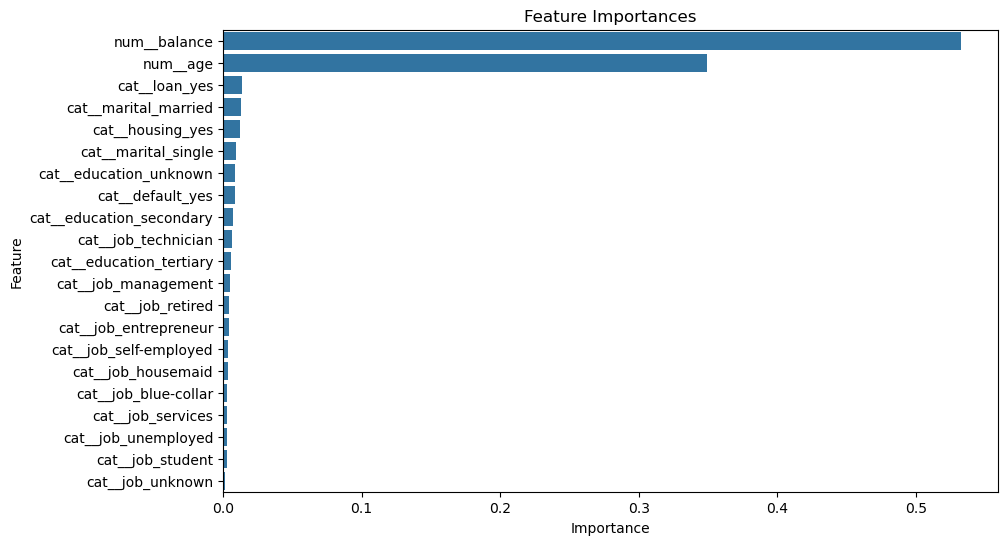


Evaluating xgb...
Cross-validation recall scores: [0.30021598 0.37365011 0.38228942 0.35344828 0.32112069]
Mean recall: 0.3461

Training Set Evaluation:
              precision    recall  f1-score   support

           0       0.98      0.79      0.88     29683
           1       0.24      0.84      0.37      2317

    accuracy                           0.80     32000
   macro avg       0.61      0.82      0.63     32000
weighted avg       0.93      0.80      0.84     32000


Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.94      0.76      0.84      7421
           1       0.10      0.35      0.16       579

    accuracy                           0.73      8000
   macro avg       0.52      0.55      0.50      8000
weighted avg       0.88      0.73      0.79      8000



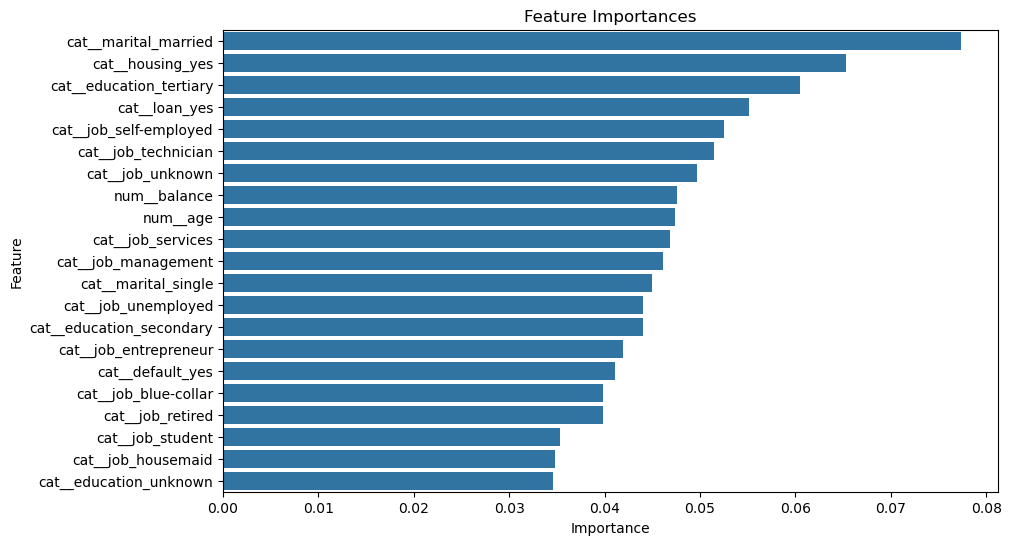


Evaluating dtc...
Cross-validation recall scores: [0.13822894 0.1187905  0.17710583 0.14439655 0.12284483]
Mean recall: 0.1403

Training Set Evaluation:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     29683
           1       0.88      1.00      0.94      2317

    accuracy                           0.99     32000
   macro avg       0.94      0.99      0.97     32000
weighted avg       0.99      0.99      0.99     32000


Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      7421
           1       0.13      0.14      0.13       579

    accuracy                           0.87      8000
   macro avg       0.53      0.53      0.53      8000
weighted avg       0.87      0.87      0.87      8000



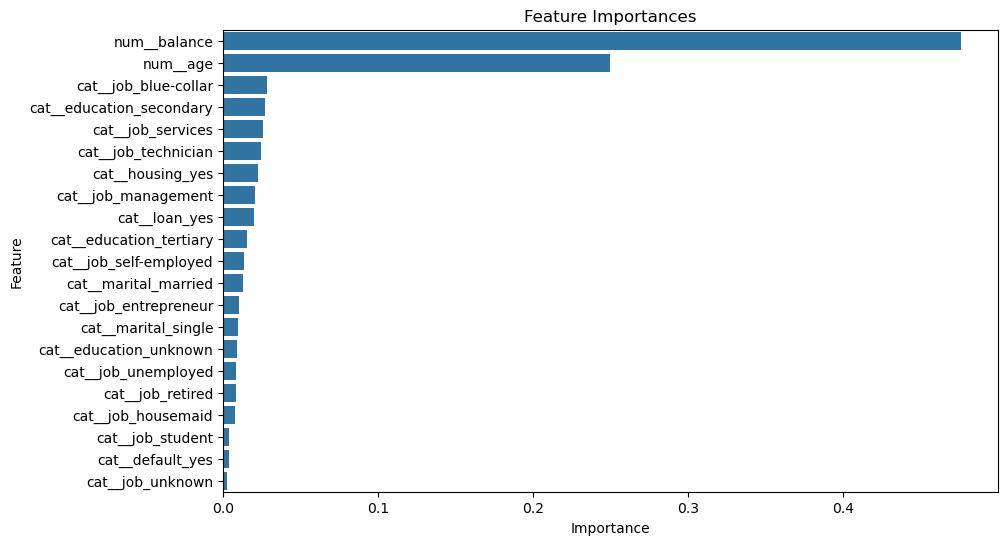


Evaluating rfc...


In [ ]:
target_column_name = 'y'

# Split the data
X_train, X_test, y_train, y_test = split_data(data, target_column_name)

# Evaluate models
for model_name, model in classifier_map.items():
    print(f"\nEvaluating {model_name}...")
    
    # Create a pipeline for each model
    pipeline = create_pipeline(model, cat_cols)
    
    # Evaluate using cross-validation on the training set
    evaluate_model(pipeline, X_train, y_train)
    
    # Perform final evaluation on the test set
    final_evaluation(pipeline, X_train, y_train, X_test, y_test)

print("\nDone!")

### Optuna with RandomForestClassifier

In [217]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline

# Create a pipeline with RandomOverSampler and Tomek Links
resample_pipeline = Pipeline(steps=[
    ('oversample', RandomOverSampler(random_state=42)),
    ('tomek', TomekLinks(sampling_strategy='majority'))
])

# Resample only the training data
X_train_resampled, y_train_resampled = resample_pipeline.fit_resample(X_train_scaled, y_train)

import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import make_scorer, f1_score, recall_score

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)

    # Create the RandomForest model with the suggested parameters
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42
    )

    # Define macro-averaged F1-score and recall scorers
    f1_scorer = make_scorer(f1_score, average='macro')
    recall_scorer = make_scorer(recall_score, average='macro')

    # Perform cross-validation and compute both F1-score and recall
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    f1_scores = cross_val_score(model, X_train_resampled, y_train_resampled, 
                                scoring=f1_scorer, cv=cv)
    recall_scores = cross_val_score(model, X_train_resampled, y_train_resampled, 
                                    scoring=recall_scorer, cv=cv)

    # Compute a weighted combination of F1-score and recall
    f1_mean = f1_scores.mean()
    recall_mean = recall_scores.mean()
    
    combined_score = 0.6 * f1_mean + 0.4 * recall_mean  # Adjust weights as needed

    return combined_score

# Create an Optuna study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print("Best trial:")
print(study.best_trial.params)

# Train the final model with the best hyperparameters
best_params = study.best_trial.params
final_model = RandomForestClassifier(**best_params, random_state=42)
final_model.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred = final_model.predict(X_test)

# Evaluate using classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

[I 2024-10-24 15:07:38,721] A new study created in memory with name: no-name-0ebb5770-1ff1-4f21-94de-44e3cdb154f9
[I 2024-10-24 15:08:50,839] Trial 0 finished with value: 0.6086987616090671 and parameters: {'n_estimators': 279, 'max_depth': 6, 'min_samples_split': 4}. Best is trial 0 with value: 0.6086987616090671.
[I 2024-10-24 15:11:06,491] Trial 1 finished with value: 0.8530655961419586 and parameters: {'n_estimators': 288, 'max_depth': 15, 'min_samples_split': 15}. Best is trial 1 with value: 0.8530655961419586.
[I 2024-10-24 15:11:45,378] Trial 2 finished with value: 0.6082169789081949 and parameters: {'n_estimators': 151, 'max_depth': 6, 'min_samples_split': 12}. Best is trial 1 with value: 0.8530655961419586.
[I 2024-10-24 15:12:07,039] Trial 3 finished with value: 0.5963402199168595 and parameters: {'n_estimators': 93, 'max_depth': 5, 'min_samples_split': 14}. Best is trial 1 with value: 0.8530655961419586.
[I 2024-10-24 15:13:37,894] Trial 4 finished with value: 0.678237454128

Best trial:
{'n_estimators': 121, 'max_depth': 20, 'min_samples_split': 4}


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- default
- education
- housing
- job
- loan
- ...
Feature names seen at fit time, yet now missing:
- default_yes
- education_secondary
- education_tertiary
- education_unknown
- housing_yes
- ...


In [218]:
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import make_scorer, f1_score, recall_score
import optuna

# Define the objective function for Optuna
def objective(trial):
    # Hyperparameter suggestions from Optuna
    n_estimators = trial.suggest_int('n_estimators', 50, 1000)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)

    # Define the RandomForest model with suggested parameters
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=seed
    )

    # Create a pipeline with RandomOverSampler and Tomek Links
    pipeline = Pipeline([
        ('oversample', RandomOverSampler(sampling_strategy='minority', random_state=seed)),
        ('tomek', TomekLinks()),
        ('classifier', model)
    ])

    # Define macro-averaged F1-score and recall scorers
    f1_scorer = make_scorer(f1_score, average='macro')
    recall_scorer = make_scorer(recall_score, average='macro')

    # Perform cross-validation
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=seed)
    f1_scores = cross_val_score(pipeline, X_train, y_train, scoring=f1_scorer, cv=cv)
    recall_scores = cross_val_score(pipeline, X_train, y_train, scoring=recall_scorer, cv=cv)

    # Compute a weighted score combining F1 and recall
    f1_mean = f1_scores.mean()
    recall_mean = recall_scores.mean()

    combined_score = 0.4 * f1_mean + 0.6 * recall_mean  # Adjust weights as needed

    return combined_score

# Create the Optuna study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)

# Print the best trial's parameters
print("Best trial:")
print(study.best_trial.params)

# Train the final model with the best parameters
best_params = study.best_trial.params
final_model = Pipeline([
    ('oversample', RandomOverSampler(sampling_strategy='minority', random_state=seed)),
    ('tomek', TomekLinks()),
    ('classifier', RandomForestClassifier(**best_params, random_state=seed))
])
final_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = final_model.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

[I 2024-10-24 16:12:31,199] A new study created in memory with name: no-name-1103519c-a5f9-45b6-b701-1273f1b80e0d
[W 2024-10-24 16:12:31,558] Trial 0 failed with parameters: {'n_estimators': 236, 'max_depth': 8, 'min_samples_split': 6} because of the following error: ValueError('\nAll the 15 fits failed.\nIt is very likely that your model is misconfigured.\nYou can try to debug the error by setting error_score=\'raise\'.\n\nBelow are more details about the failures:\n--------------------------------------------------------------------------------\n15 fits failed with the following error:\nTraceback (most recent call last):\n  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score\n    estimator.fit(X_train, y_train, **fit_params)\n  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/base.py", line 1473, in wrapper\n    return fit_method(estimator, *args, **kw

ValueError: 
All the 15 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/imblearn/pipeline.py", line 329, in fit
    Xt, yt = self._fit(X, y, routed_params)
  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/imblearn/pipeline.py", line 265, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/joblib/memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/imblearn/pipeline.py", line 1057, in _fit_resample_one
    X_res, y_res = sampler.fit_resample(X, y, **params.get("fit_resample", {}))
  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/imblearn/base.py", line 208, in fit_resample
    return super().fit_resample(X, y)
  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/imblearn/base.py", line 106, in fit_resample
    X, y, binarize_y = self._check_X_y(X, y)
  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/imblearn/base.py", line 161, in _check_X_y
    X, y = self._validate_data(X, y, reset=True, accept_sparse=accept_sparse)
  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/utils/validation.py", line 1301, in check_X_y
    X = check_array(
  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/utils/validation.py", line 1012, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/utils/_array_api.py", line 751, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/pandas/core/generic.py", line 2153, in __array__
    arr = np.asarray(values, dtype=dtype)
ValueError: could not convert string to float: 'blue-collar'


In [225]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as SklearnPipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Define your preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', StandardScaler(), num_cols)
    ]
)

# Function to apply resampling only on the training data
def resample_data(X, y):
    X_res, y_res = RandomOverSampler(random_state=seed).fit_resample(X, y)
    X_res, y_res = TomekLinks(sampling_strategy='not majority').fit_resample(X_res, y_res)
    return X_res, y_res

# Wrap the resampling logic in FunctionTransformer
resample_transformer = FunctionTransformer(lambda X: X, validate=False)

# Create the full pipeline
model_pipeline = SklearnPipeline(steps=[
    ('preprocessor', preprocessor),
    ('resample', resample_transformer),  # Wrapper to skip transformation
    ('classifier', RandomForestClassifier(random_state=seed))
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=seed
)

# Apply resampling on the training data only
X_train_res, y_train_res = resample_data(X_train, y_train)

# Fit the model on resampled training data
model_pipeline.fit(X_train_res, y_train_res)

# Predict on the test set
y_pred = model_pipeline.predict(X_test)

# Evaluate the model's performance
print(classification_report(y_test, y_pred))


ValueError: could not convert string to float: 'admin'

## Modeling: Layer 2

### Layer 2: Use the full X dataset to model which customers the bank should keep calling

In [ ]:
X_2.head(3)

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   

   contact  day month  duration  campaign  
0  unknown    5   may       261         1  
1  unknown    5   may       151         1  
2  unknown    5   may        76         1

In [ ]:
splits_2,pipeline_2,results_2=\
run_autosklearn_pipeline(X=X_2,
                         y=y,
                         seed=seed,
                         verbose=True,
                         test_size=test_size,
                         save_location='../joblib/',
                         filename='2_pipeline_20240821_layer2',
                         time_for_task=3600)

Categorical and continuous features detected
Preprocessor created
categorical_features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month']
continuous_features: ['age', 'balance', 'day', 'duration', 'campaign']
Training and testing splits created
AutoSklearnClassifier and pipeline created

Training the pipeline... (This may take up to 60 minutes)




In [ ]:
results_2=returnTopModels('../joblib/2_pipeline_20240821_layer2')
results_2

random_forest          23
mlp                     5
liblinear_svc           3
k_nearest_neighbors     2
extra_trees             2
passive_aggressive      1
gaussian_nb             1
bernoulli_nb            1
Name: param_classifier:__choice__, dtype: int64

In [ ]:
pipeline_2=joblib.load('../joblib/2_pipeline_20240821_layer2')
splits_2=joblib.load('../joblib/2_pipeline_20240821_layer2_splits')

In [ ]:
X_2_test=splits_2['X_test']
y_2_test=splits_2['y_test']

y_2_pred,accuracy_2=evaluateModel(X_2_test,y_2_test,pipeline_2,verbose=True)

AutoSklearn accuracy:
93.77%


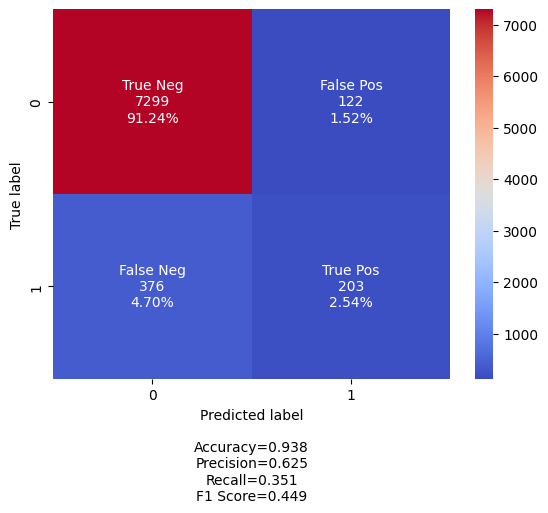

In [ ]:
# view confusion matrix
# the F1-score doesn't show but that's ok
cf_matrix_2=confusion_matrix(y_2_test,y_2_pred)
labels=['True Neg','False Pos','False Neg','True Pos']
make_confusion_matrix(cf=cf_matrix_2,
                      group_names=labels,
                      cmap='coolwarm')

In [ ]:
# view F1-score
creport=classification_report(y_test,y_2_pred)
print(creport)

              precision    recall  f1-score   support

          no       0.95      0.98      0.97      7421
         yes       0.62      0.35      0.45       579

    accuracy                           0.94      8000
   macro avg       0.79      0.67      0.71      8000
weighted avg       0.93      0.94      0.93      8000



This is also a great result.